Geo-columns to handle in the next notebook:
* Latitude
* Longitude
* O'Hare Noise 
* Floodplain
* Near Major Road


Other columns to handle:
* Age Squared
* everything after Age Squared

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from urllib.request import urlretrieve
from IPython.core.display import display, HTML

%matplotlib inline

In [2]:
import geopandas as gpd
from typing import Dict, List, Union, Optional
from textwrap import wrap
import missingno as msno
from shapely.geometry import Point
from scipy.spatial import cKDTree
import itertools
from operator import itemgetter

In [3]:
pd.options.display.max_columns = None
# pd.set_option("display.max_columns", None)
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import utils

In [5]:
dir(utils)

['CategoricalDtype',
 'Dict',
 'List',
 'Optional',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'clean_cc_real_estate_sales_arms_length_col',
 'clean_cc_real_estate_sales_data',
 'clean_cc_real_estate_sales_date_cols',
 'clean_cc_real_estate_sales_deed_type_col',
 'clean_cc_residential_neighborhood_geodata',
 'clean_cc_residential_prop_chars_age_col',
 'clean_cc_residential_prop_chars_apartments_col',
 'clean_cc_residential_prop_chars_attic_finish_col',
 'clean_cc_residential_prop_chars_attic_type_col',
 'clean_cc_residential_prop_chars_basement_col',
 'clean_cc_residential_prop_chars_basement_finish_col',
 'clean_cc_residential_prop_chars_bedrooms_col',
 'clean_cc_residential_prop_chars_cathedral_ceiling_col',
 'clean_cc_residential_prop_chars_cdu_col',
 'clean_cc_residential_prop_chars_census_tract_col',
 'clean_cc_residential_prop_chars_central_air_col',
 'clean_cc_residential_prop_chars_central_heating

https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Property-Charac/bcnq-qi2z

In [6]:
cc_res_prop_char_df = utils.clean_cc_residential_property_characteristics_data()

In [7]:
cc_res_prop_char_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr
0,1011000040000,212,2018,012,11055,10,two story,5,Wood,Tar and Gravel,7,5,Partial,Unfinished,Warm air,none,False,0,Full,Unfinished,1,Stock Plan,No,Average,NaN,Not relevant to Value,1.5 car,Frame,No,"No, garage area not included in building area",None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,3,1904,Average,One building,1,52510,374930,NaT,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,False,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,NaN,Yes,False,NaN,NaN,0,0,1,1,NaN,18225,13.5,182.25,122213025,3625216,2.084499,1,<NA>,0,0,12,105.14276,11.61895,43.634848,1012,mixed_use_bldg_w_lte_6_units__any_age__gte_20k...
1,1011000050000,205,2018,012,6534,10,two story,0,Wood,Shingle/Asphalt,7,4,Full,Unfinished,Hot water steam,none,False,1,Full,Unfinished,0,Stock Plan,No,Average,NaN,Not relevant to Value,2 car,Frame,No,"No, garage area not included in building area",None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,1,1562,Average,One building,0,31030,173970,NaT,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,False,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,NaN,NaN,False,NaN,NaN,0,0,1,1,NaN,12996,11.4,129.96,42693156,2439844,2.079861,1,<NA>,0,0,12,80.833162,10.677078,39.522146,1012,two_plus_story_residence__gt_62_yrs_old__lt_22...


### O'Hare Noise
* Indicator for the property under O'Hare approach flight path, within 1/4 mile.

### Floodplain
* Indicator for properties on a floodplain, defined as a FEMA Special Flood Hazard Area 

### Near Major Road
* Indicates whether the property is within 300 ft of a major road. 

These are geo-columns, like Latitude and Longitude, and I'll deal with those at the end.

### Age Squared
* Age Squared 

This feature seem

<AxesSubplot:ylabel='Frequency'>

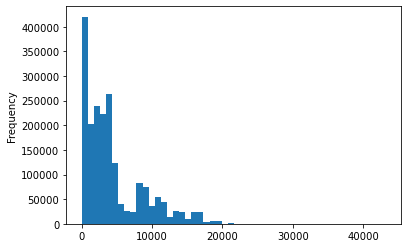

In [8]:
(cc_res_prop_char_df["Age"].pow(2)).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

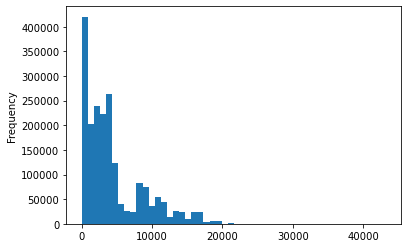

In [9]:
(cc_res_prop_char_df["Age Squared"]).plot.hist(bins=50)

Ok. As expected, `Age Squared` isn't bringing any new info. I'll make a note that it might be useful to recreate later in modeling, but for now, I'm dropping it as it's trivially easy to recreate from `Age`.

### Age Decade
* Age in decades 

In [12]:
cc_res_prop_char_df["Age Decade"].value_counts(dropna=False)

1.0     60807
6.2     43847
6.1     39770
6.3     39611
6.4     37510
        ...  
20.3        1
18.0        1
17.4        1
18.8        1
NaN         0
Name: Age Decade, Length: 189, dtype: Int64

Oh, wow. It's not even binning ages, it's just dividing by 10.

In [13]:
cc_res_prop_char_df["Age"].value_counts(dropna=False)

10     60807
62     43847
61     39770
63     39611
64     37510
       ...  
203        1
180        1
174        1
188        1
NaN        0
Name: Age, Length: 189, dtype: Int64

<AxesSubplot:ylabel='Frequency'>

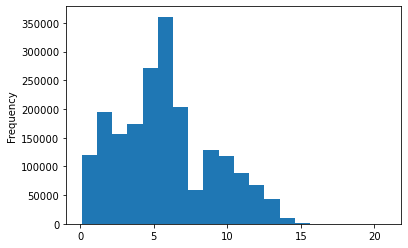

In [11]:
(cc_res_prop_char_df["Age Decade"]).plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

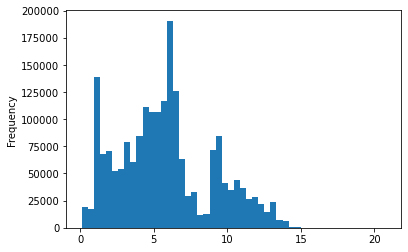

In [14]:
(cc_res_prop_char_df["Age Decade"]).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

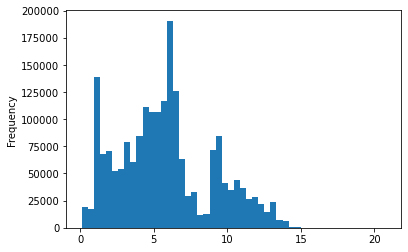

In [15]:
(cc_res_prop_char_df["Age"].div(10)).plot.hist(bins=50)

Ok. As expected, `Age Decade` also isn't bringing any new info. I'll make a note that it might be useful to recreate later in modeling, but for now, I'm dropping it as it's trivially easy to recreate from `Age`.

### Age Decade Squared
* Age in decades squared 

<AxesSubplot:ylabel='Frequency'>

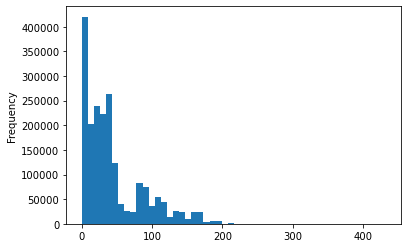

In [16]:
(cc_res_prop_char_df["Age Decade Squared"]).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

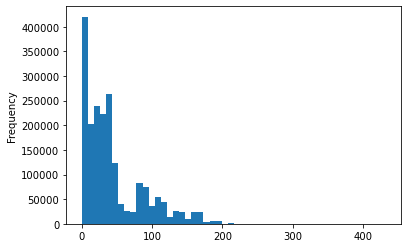

In [18]:
(cc_res_prop_char_df["Age Decade"].pow(2)).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

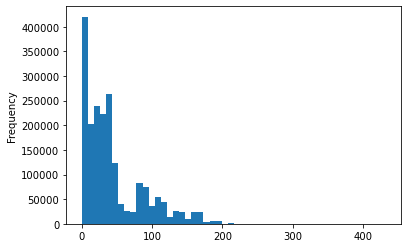

In [19]:
(cc_res_prop_char_df["Age"].div(10).pow(2)).plot.hist(bins=50)

`Age Decade Squared` is not bringing anything new. I'll note its possible modeling value like I did with the others, but I don't see a reason to lug it around until then.

### Lot Size Squared
* Lot Size Squared 

<AxesSubplot:ylabel='Frequency'>

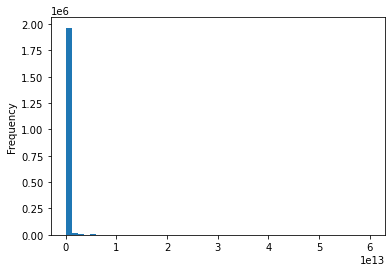

In [22]:
(cc_res_prop_char_df["Lot Size Squared"]).plot.hist(bins=50)

(0.0, 100000000000.0)

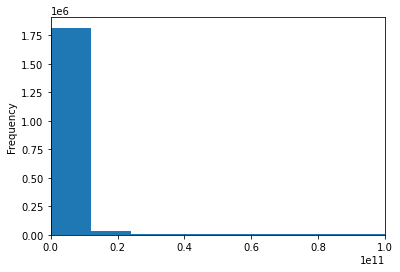

In [30]:
ax = (cc_res_prop_char_df["Lot Size Squared"]).plot.hist(bins=5000)
ax.set_xlim(0, 100000000000)

<AxesSubplot:ylabel='Frequency'>

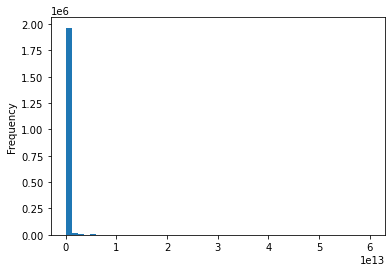

In [24]:
(cc_res_prop_char_df["Land Square Feet"].pow(2)).plot.hist(bins=50)

(0.0, 100000000000.0)

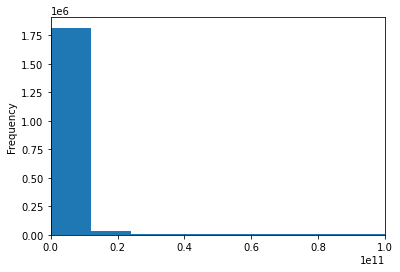

In [28]:
ax = (cc_res_prop_char_df["Land Square Feet"].pow(2)).plot.hist(bins=5000)
ax.set_xlim(0, 100000000000)

Ok, another redundant feature.

### Improvement Size Squared
* Building square feet, squared

<AxesSubplot:ylabel='Frequency'>

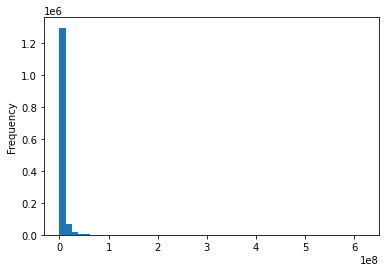

In [31]:
(cc_res_prop_char_df["Improvement Size Squared"]).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

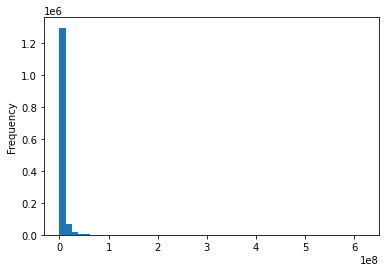

In [32]:
(cc_res_prop_char_df["Building Square Feet"].pow(2)).plot.hist(bins=50)

Yet another redundant feature.

### Location Factor
* Calculated from a geographically weighted regression. Captures the relationship between home value and geographic location. 

Hmmmmm. This seems like something worth spending the time to understand. It seems like a lot of harm or unfairness could get packed into this feature.

<AxesSubplot:ylabel='Frequency'>

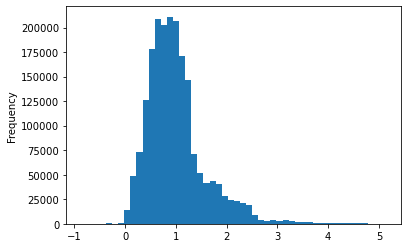

In [33]:
(cc_res_prop_char_df["Location Factor"]).plot.hist(bins=50)

### Garage indicator
* Indicates presence of a garage of any size. 

In [34]:
cc_res_prop_char_df["Garage indicator"].value_counts(dropna=False)

1      1177185
NaN     602017
0       215906
Name: Garage indicator, dtype: Int64

In [35]:
def clean_cc_residential_prop_chars_garage_indicator_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Indicates presence of a garage of any size."""
    df["Garage indicator"] = df["Garage indicator"].astype("boolean")
    return df

In [36]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_indicator_col(cc_res_prop_char_df)

In [37]:
cc_res_prop_char_df["Garage indicator"].value_counts(dropna=False)

True     1177185
NaN       602017
False     215906
Name: Garage indicator, dtype: Int64

### Residential share of building
* A sum of "percent of ownership" that only includes residential units within a condo building. 

<AxesSubplot:ylabel='Frequency'>

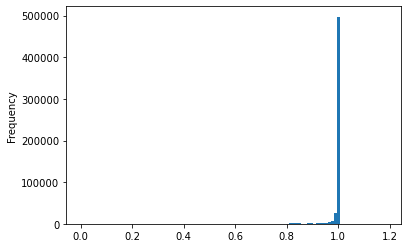

In [39]:
(cc_res_prop_char_df["Residential share of building"]).plot.hist(bins=100)

In [41]:
cc_res_prop_char_df["Residential share of building"].value_counts(dropna=False)

NaN          1433884
1.0           294354
0.9999          3838
1.0000002       3439
0.999998        2917
              ...   
0.0235             1
0.6494             1
0.0545758          1
0.335              1
0.4                1
Name: Residential share of building, Length: 1541, dtype: Int64

In [44]:
cc_res_prop_char_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr
0,1011000040000,212,2018,012,11055,10,two story,5,Wood,Tar and Gravel,7,5,Partial,Unfinished,Warm air,none,False,0,Full,Unfinished,1,Stock Plan,No,Average,NaN,Not relevant to Value,1.5 car,Frame,No,"No, garage area not included in building area",None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,3,1904,Average,One building,1,52510,374930,NaT,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,False,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,NaN,Yes,False,NaN,NaN,0,0,1,1,NaN,18225,13.5,182.25,122213025,3625216,2.084499,True,<NA>,0,0,12,105.14276,11.61895,43.634848,1012,mixed_use_bldg_w_lte_6_units__any_age__gte_20k...
1,1011000050000,205,2018,012,6534,10,two story,0,Wood,Shingle/Asphalt,7,4,Full,Unfinished,Hot water steam,none,False,1,Full,Unfinished,0,Stock Plan,No,Average,NaN,Not relevant to Value,2 car,Frame,No,"No, garage area not included in building area",None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,1,1562,Average,One building,0,31030,173970,NaT,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,False,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,NaN,NaN,False,NaN,NaN,0,0,1,1,NaN,12996,11.4,129.96,42693156,2439844,2.079861,True,<NA>,0,0,12,80.833162,10.677078,39.522146,1012,two_plus_story_residence__gt_62_yrs_old__lt_22...


In [47]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Residential share of building"] > 1,
    ["PIN", "Property Address", "Number of Units", "Number of Commercial Units",
     "Percent Ownership", "Residential share of building", "Condo Strata"]
]

,PIN,Property Address,Number of Units,Number of Commercial Units,Percent Ownership,Residential share of building,Condo Strata
642,3021000821248,40 PRAIRIE PARK DR,588,<NA>,0.0,1.00002,10
746,3021000821236,100 PRAIRIE PARK DR,588,<NA>,0.0,1.00002,10
1097,3021000821492,100 PRAIRIE PARK DR,588,<NA>,0.0,1.00002,10
2277,3021000821389,100 PRAIRIE PARK DR,588,<NA>,0.0,1.00002,10
2913,3021000821370,115 PRAIRIE PARK DR,588,<NA>,0.0,1.00002,10
...,...,...,...,...,...,...,...
1992759,33072000121019,2817 GLENWOOD LANSING RD,32,<NA>,0.03,1.01,1
1992760,33072000121024,2807 GLENWOOD LANSING RD,32,<NA>,0.04,1.01,1
1992761,33072000121021,2809 GLENWOOD LANSING RD,32,<NA>,0.04,1.01,1
1992762,33072000121022,2809 GLENWOOD LANSING RD,32,<NA>,0.03,1.01,1


In [50]:
cc_res_prop_char_df["Residential share of building"].max()

1.1862

In [55]:
cc_res_prop_char_df["Residential share of building"].notnull().sum()

561224

In [60]:
pct_w_impossible_values = round(
    100 * (cc_res_prop_char_df["Residential share of building"] > 1).sum() / 
    cc_res_prop_char_df["Residential share of building"].notnull().sum(),
    4
)
print(f"Percent of records (with non-null values) with an impossible ")
print(f"'Residential share of building' value: {pct_w_impossible_values}% ")

Percent of records (with non-null values) with an impossible 
'Residential share of building' value: 12.8756% 


In [64]:
threshold = 1.01
pct_w_impossible_values = round(
    100 * (cc_res_prop_char_df["Residential share of building"] > threshold).sum() / 
    cc_res_prop_char_df["Residential share of building"].notnull().sum(),
    4
)
print(f"Percent of records (with non-null values) with a 'Residential share")
print(f"of building' value above {threshold}: {pct_w_impossible_values}% ")

Percent of records (with non-null values) with a 'Residential share
of building' value above 1.01: 0.0656% 


In [62]:
threshold = 1.02
pct_w_impossible_values = round(
    100 * (cc_res_prop_char_df["Residential share of building"] > threshold).sum() / 
    cc_res_prop_char_df["Residential share of building"].notnull().sum(),
    4
)
print(f"Percent of records (with non-null values) with a 'Residential share")
print(f"of building' value above {threshold}: {pct_w_impossible_values}% ")

Percent of records (with non-null values) with a 'Residential share
of building' value above 1.02: 0.0369% 


Hmm. 100.002% implies a rounded percentages were summed. 118.62% implies an error. Still, a brief spotcheck shows the properties connected to these impossible `Residential share of building` values are all residential. Nearly 13% of all records with a non-null value for this feature have an impossible value, but most of those are likely just rounding errors, as less than 0.07% of all non-null records for this feature are above 101%. I don't know if any extra information is encoded in this feature, or if there's some definitional weirdness that makes these values legal, but I'm going to make the arbitrary choice of flattening values in the range [1.000 to 1.010] to 1.000, and values above 1.01 to 1.01.

In [54]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Residential share of building"] > 1.1,
    ["PIN", "Property Address", "Number of Units", "Number of Commercial Units",
     "Percent Ownership", "Residential share of building", "Condo Strata"]
]

,PIN,Property Address,Number of Units,Number of Commercial Units,Percent Ownership,Residential share of building,Condo Strata
1078536,14293140501002,2555 N SOUTHPORT AVE,4,<NA>,0.24,1.1211,NaN
1078537,14293140501004,2555 N SOUTHPORT AVE,4,<NA>,0.27,1.1211,NaN
1078538,14293140501003,2555 N SOUTHPORT AVE,4,<NA>,0.25,1.1211,NaN
1078539,14293140501001,2555 N SOUTHPORT AVE,4,<NA>,0.24,1.1211,NaN
1167963,16014040461002,2727 W HADDON AVE,3,<NA>,0.25,1.1862,NaN
1167964,16014040461003,2727 W HADDON AVE,3,<NA>,0.34,1.1862,NaN
1167965,16014040461001,2727 W HADDON AVE,3,<NA>,0.41,1.1862,NaN


<AxesSubplot:ylabel='Frequency'>

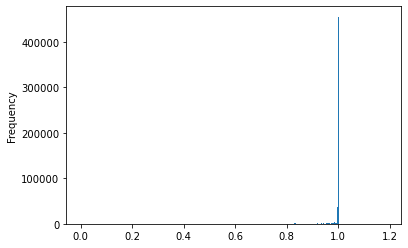

In [65]:
(cc_res_prop_char_df["Residential share of building"]).plot.hist(bins=500)

In [66]:
df = cc_res_prop_char_df

rounding_error_mask = (
    (df["Residential share of building"] > 1) & 
    (df["Residential share of building"] < 1.01)
)
bigger_error_mask = (df["Residential share of building"] >= 1.01)
df.loc[rounding_error_mask, "Residential share of building"] = 1
df.loc[bigger_error_mask, "Residential share of building"] = 1.01

In [71]:
def clean_cc_residential_prop_chars_residential_share_of_building_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    rounding_error_mask = (
        (df["Residential share of building"] > 1) & 
        (df["Residential share of building"] < 1.01)
    )
    bigger_error_mask = (df["Residential share of building"] >= 1.01)
    df.loc[rounding_error_mask, "Residential share of building"] = 1
    df.loc[bigger_error_mask, "Residential share of building"] = 1.01
    return df

In [72]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_residential_share_of_building_col(cc_res_prop_char_df)

<AxesSubplot:ylabel='Frequency'>

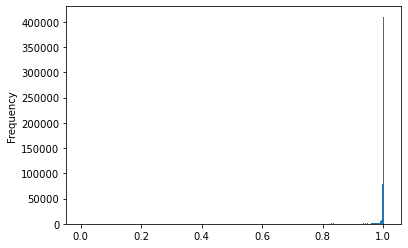

In [73]:
(cc_res_prop_char_df["Residential share of building"]).plot.hist(bins=500)

In [74]:
cc_res_prop_char_df["Residential share of building"].max()

1.01

### Pure Market Sale
* Indicator for pure market sale.

In [75]:
cc_res_prop_char_df["Pure Market Sale"].value_counts(dropna=False)

0      1908583
1        86525
NaN          0
Name: Pure Market Sale, dtype: Int64

In [85]:
def clean_cc_residential_prop_chars_pure_market_sale_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Indicator for pure market sale."""
    df["Pure Market Sale"] = df["Pure Market Sale"].astype("boolean")
    return df

In [77]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_pure_market_sale_col(cc_res_prop_char_df)

In [78]:
cc_res_prop_char_df["Pure Market Sale"].value_counts(dropna=False)

False    1908583
True       86525
NaN            0
Name: Pure Market Sale, dtype: Int64

### Pure Market Filter
* Indicator for pure market sale.

Hmmm. Is this different from `Pure Market Sale`?

In [79]:
cc_res_prop_char_df["Pure Market Filter"].value_counts(dropna=False)

0      1908583
1        86525
NaN          0
Name: Pure Market Filter, dtype: Int64

In [80]:
(cc_res_prop_char_df["Pure Market Filter"].astype("boolean") != cc_res_prop_char_df["Pure Market Sale"]).sum()

0

Ok, there are 0 records where these columns have different values. I'm going to drop the latter.

### Neigborhood Code (mapping)
* Unmodified neighborhood code that can be used for mapping. 

In [84]:
cc_res_prop_char_df["Neighborhood Code"].value_counts(dropna=False)

030    110964
010     92851
070     71885
050     71720
031     70803
        ...  
038        85
580        55
145        50
599         4
999         1
Name: Neighborhood Code, Length: 199, dtype: int64

In [82]:
cc_res_prop_char_df["Neigborhood Code (mapping)"].value_counts(dropna=False)

30     110964
10      92851
70      71885
50      71720
31      70803
        ...  
580        55
145        50
599         4
999         1
NaN         0
Name: Neigborhood Code (mapping), Length: 200, dtype: Int64

In [86]:
df = cc_res_prop_char_df.copy()

In [87]:
df = df.rename(columns={"Neigborhood Code (mapping)": "Neighborhood Code (mapping)"})

In [ ]:
cc_res_prop_char_df["Neigborhood Code (mapping)"]

In [89]:
df["Neighborhood Code (mapping)"] = df["Neighborhood Code (mapping)"].astype("string")
df["Neighborhood Code (mapping)"] = df["Neighborhood Code (mapping)"].str.zfill(3)
df["Neighborhood Code (mapping)"] = df["Neighborhood Code (mapping)"].astype("category")

In [91]:
df["Neighborhood Code (mapping)"].value_counts(dropna=False)

030    110964
010     92851
070     71885
050     71720
031     70803
        ...  
038        85
580        55
145        50
599         4
999         1
Name: Neighborhood Code (mapping), Length: 199, dtype: int64

In [92]:
df.loc[
    df["Neighborhood Code"] != df["Neighborhood Code (mapping)"]
]

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neighborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr


In [94]:
df.loc[
    df["Neighborhood Code"] == df["Neighborhood Code (mapping)"]
].shape

(1995108, 82)

In [95]:
df.shape

(1995108, 82)

Ok, this column also doesn't add any new information, as (after light string formatting) it matches the `Neighborhood Code` feature for every record. Adding `Neigborhood Code (mapping)` to the drop list.

### Square root of lot size
* Square root of lot size.

<AxesSubplot:ylabel='Frequency'>

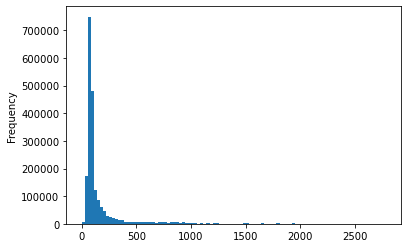

In [97]:
(cc_res_prop_char_df["Square root of lot size"]).plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

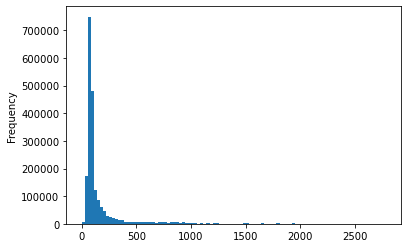

In [98]:
(cc_res_prop_char_df["Land Square Feet"].pow(0.5)).plot.hist(bins=100)

In [109]:
cc_res_prop_char_df["Land Square Feet"].pow(0.5).head(2)

0    105.14276
1    80.833162
Name: Land Square Feet, dtype: Float64

In [99]:
(cc_res_prop_char_df["Land Square Feet"].pow(0.5) != cc_res_prop_char_df["Square root of lot size"]).sum()

1490940

Ok, my calculated square-root-of-land-area values are not exactly equal to the provided `Square root of lot size` values, but it's possible that's just a floating point issue. Let's check the magnitude of the difference.

In [106]:
df = cc_res_prop_char_df[["Square root of lot size", "Land Square Feet"]].copy()
df["sqrt_Land Square Feet"] = df["Land Square Feet"].pow(0.5)
df["diff"] = df["Square root of lot size"] - df["sqrt_Land Square Feet"]

In [107]:
df.head(2)

,Square root of lot size,Land Square Feet,sqrt_Land Square Feet,diff
0,105.14276,11055,105.14276,0.0
1,80.833162,6534,80.833162,0.0


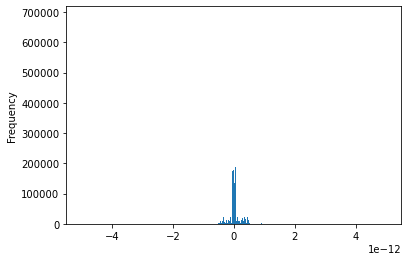

In [108]:
ax = (df["diff"]).plot.hist(bins=500)
# ax.set_xlim(0, 100000000000)

In [111]:
print(f"Magnitude of largest difference: {df['diff'].abs().max()}")

Magnitude of largest difference: 5.002220859751105e-12


That confirms it. The magnitude of the largest difference between my calculated values and the provided values is $5 \times 10^{-12}$ ft (or $0.000000000005$ ft).

Thus, the `Square root of lot size` feature is just another field calculated from `Lot Size` and I'll drop it for now.

### Square root of age
* Square root of age of improvement.

<AxesSubplot:ylabel='Frequency'>

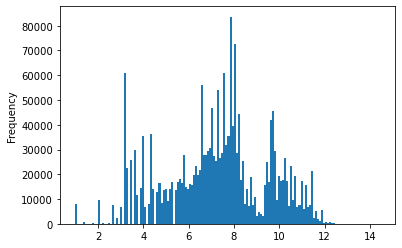

In [114]:
(cc_res_prop_char_df["Square root of age"]).plot.hist(bins=150)

<AxesSubplot:ylabel='Frequency'>

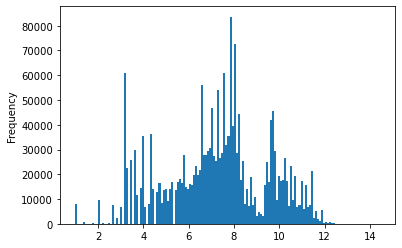

In [115]:
(cc_res_prop_char_df["Age"].pow(0.5)).plot.hist(bins=150)

In [116]:
df = cc_res_prop_char_df[["Square root of age", "Age"]].copy()
df["sqrt_Age"] = df["Age"].pow(0.5)
df["diff"] = df["Square root of age"] - df["sqrt_Age"]

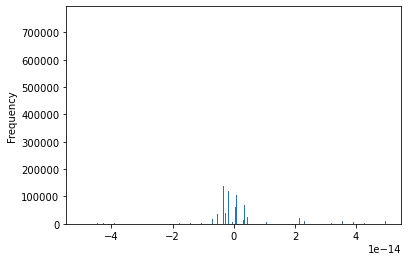

In [117]:
ax = (df["diff"]).plot.hist(bins=500)

As expected, `Square root of age` is also a calculated field that I can remake easily later if I think it would be useful in modeling.

### Square root of improvement size
* Square root of improvement size 

<AxesSubplot:ylabel='Frequency'>

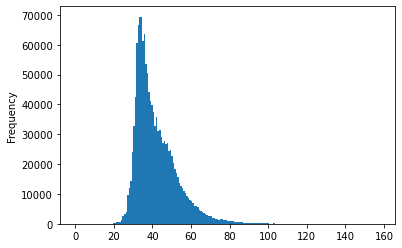

In [119]:
(cc_res_prop_char_df["Square root of improvement size"]).plot.hist(bins=200)

<AxesSubplot:ylabel='Frequency'>

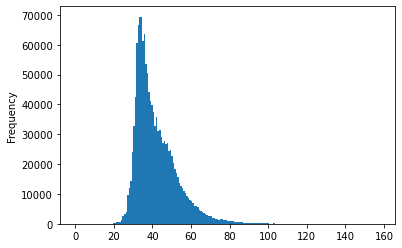

In [120]:
(cc_res_prop_char_df["Building Square Feet"].pow(0.5)).plot.hist(bins=200)

In [121]:
df = cc_res_prop_char_df[["Square root of improvement size", "Building Square Feet"]].copy()
df["sqrt_Building Square Feet"] = df["Building Square Feet"].pow(0.5)
df["diff"] = df["Square root of improvement size"] - df["sqrt_Building Square Feet"]

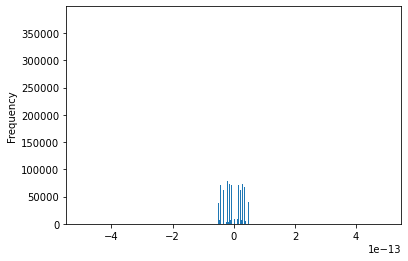

In [122]:
ax = (df["diff"]).plot.hist(bins=500)

As expected, `Square root of improvement size` is another calculated field that I can remake easily later if I think it would be useful in modeling.

### Town and Neighborhood
* Combination of town and neighborhood used to uniquely neighborhoods across townships. 

In [123]:
cc_res_prop_char_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr
0,1011000040000,212,2018,012,11055,10,two story,5,Wood,Tar and Gravel,7,5,Partial,Unfinished,Warm air,none,False,0,Full,Unfinished,1,Stock Plan,No,Average,NaN,Not relevant to Value,1.5 car,Frame,No,"No, garage area not included in building area",None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,3,1904,Average,One building,1,52510,374930,NaT,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,False,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,NaN,Yes,False,NaN,NaN,0,0,1,1,NaN,18225,13.5,182.25,122213025,3625216,2.084499,True,<NA>,False,0,12,105.14276,11.61895,43.634848,1012,mixed_use_bldg_w_lte_6_units__any_age__gte_20k...
1,1011000050000,205,2018,012,6534,10,two story,0,Wood,Shingle/Asphalt,7,4,Full,Unfinished,Hot water steam,none,False,1,Full,Unfinished,0,Stock Plan,No,Average,NaN,Not relevant to Value,2 car,Frame,No,"No, garage area not included in building area",None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,1,1562,Average,One building,0,31030,173970,NaT,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,False,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,NaN,NaN,False,NaN,NaN,0,0,1,1,NaN,12996,11.4,129.96,42693156,2439844,2.079861,True,<NA>,False,0,12,80.833162,10.677078,39.522146,1012,two_plus_story_residence__gt_62_yrs_old__lt_22...


In [124]:
cc_res_prop_char_df["Town and Neighborhood"].value_counts(dropna=False)

7430     29972
2431     28771
7422     23049
2481     21500
77131    19069
         ...  
25310       26
3082        25
71599        4
34999        1
NaN          0
Name: Town and Neighborhood, Length: 853, dtype: Int64

In [126]:
df = cc_res_prop_char_df[["Town and Neighborhood", "Town Code", "Neighborhood Code"]].copy()

In [128]:
df.head(2)

,Town and Neighborhood,Town Code,Neighborhood Code
0,1012,10,012
1,1012,10,012


In [131]:
df["Town and Neighborhood"] = df["Town Code"].astype("string") + df["Neighborhood Code"].astype("string")
df["Town and Neighborhood"] = df["Town and Neighborhood"].astype("category")

In [133]:
def clean_cc_residential_prop_chars_town_and_neighborhood_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Town and Neighborhood"] = df["Town Code"].astype("string") + df["Neighborhood Code"].astype("string")
    df["Town and Neighborhood"] = df["Town and Neighborhood"].astype("category")
    return df

In [134]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_town_and_neighborhood_col(cc_res_prop_char_df)

In [135]:
cc_res_prop_char_df["Town and Neighborhood"].value_counts(dropna=False)

74030    29972
24031    28771
74022    23049
24081    21500
77131    19069
         ...  
30100       37
25310       26
30082       25
71599        4
34999        1
Name: Town and Neighborhood, Length: 852, dtype: int64

In [6]:
cc_res_prop_char_df = utils.get_raw_cc_residential_property_characteristics_data()
# cc_res_prop_char_df = cc_res_prop_char_df.convert_dtypes()

In [7]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_property_class_col(
    df=cc_res_prop_char_df
)

* **PIN**
    * Unique Permanent Identification Number for each property. All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 2 digits for block + 2 digits for parcel + 4 digits for the multicode

* **Tax Year**
    * Tax year of sale. Tax year referrs to the year in which taxes due. Taxes are billed a year in arrears. If a sale ocurred in calendar year 2018, it will be in tax year 2019.
    
No real issues in this feature.

In [8]:
cc_res_prop_char_df["Tax Year"].value_counts(dropna=False)

2019    1583785
2018     411323
NaN           0
Name: Tax Year, dtype: Int64

### **Neighborhood Code**
    * Neighborhood code as assigned by the Assessment office. An interactive map is available at https://maps.cookcountyil.gov/cookviewer/.

In [9]:
cc_res_prop_char_df["Neighborhood Code"].value_counts(dropna=False)

30     110964
10      92851
70      71885
50      71720
31      70803
        ...  
580        55
145        50
599         4
999         1
NaN         0
Name: Neighborhood Code, Length: 200, dtype: Int64

In [10]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_neighborhood_code_col(cc_res_prop_char_df)

In [11]:
cc_res_prop_char_df["Neighborhood Code"].value_counts(dropna=False)

030    110964
010     92851
070     71885
050     71720
031     70803
        ...  
038        85
580        55
145        50
599         4
999         1
Name: Neighborhood Code, Length: 199, dtype: int64

### **Land Square Feet**
    * Square feet of the land (not just the building) of the property. Note that land is divided into 'plots' and 'parcels' - this field applies to parcels, identified by PIN.

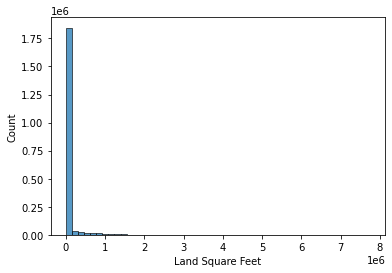

In [12]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Land Square Feet", bins=50)

(0.0, 100000.0)

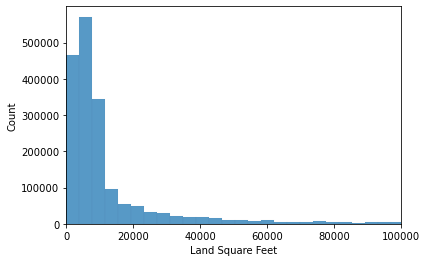

In [13]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Land Square Feet", bins=2000)
ax.set_xlim(0, 100000)

### Town Code
* Township code as assigned by the Assessment office. An interactive map is available at https://maps.cookcountyil.gov/cookviewer/.

In [14]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_town_code_col(cc_res_prop_char_df)

In [16]:
cc_res_prop_char_df["Town Code"].value_counts(dropna=False)

72    151861
71    139753
77    112670
38    111341
22     97889
73     92470
35     88665
70     82673
24     82146
29     80601
74     71093
25     65521
18     63240
76     60728
37     60075
16     58389
20     57156
39     57069
31     48072
17     44716
23     42817
13     40605
21     38040
28     37161
12     30131
32     26303
75     20300
30     20140
26     18204
27     17328
15     14529
11     14121
36     13164
10     12512
19      8006
34      5908
14      5439
33      4272
Name: Town Code, dtype: int64

### Type of Residence
* Type of residence - 1 = one story, 2 = two-story, 3 = three-story or higher, 4 = split level, 5 = 1.5 story, 6 = 1.6 story, 7 = 1.7 story , 8 = 1.8 story , 9 = 1.9 story (Note: residences with 1.5 - 1.9 stories are one story and have partial livable attics and are classified based on the square footage of the attic compared to the first floor of the house. So, 1.5 story houses have an attic that is 50% of the area of the first floor, 1.6 story houses are 60%, 1.7 are 70%, etc. However, what is recorded on the field card differs from what is in the database. All 1.5 - 1.9 story houses are coded as 5).

In [17]:
cc_res_prop_char_df["Type of Residence"].value_counts(dropna=False)

NaN    602055
2      552786
1      540166
4      130510
5      130080
3       39398
7          39
8          33
6          23
9          18
Name: Type of Residence, dtype: Int64

In [18]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_type_of_residence_col(cc_res_prop_char_df)

In [19]:
cc_res_prop_char_df["Type of Residence"].value_counts(dropna=False)

NaN                                                                            602055
two story                                                                      552786
one story                                                                      540166
split level                                                                    130510
1.5 story (one story w/ partial livable attic; 50% sq footage of 1st floor)    130080
three story or higher                                                           39398
1.7 story (one story w/ partial livable attic; 70% sq footage of 1st floor)        39
1.8 story (one story w/ partial livable attic; 80% sq footage of 1st floor)        33
1.6 story (one story w/ partial livable attic; 60% sq footage of 1st floor)        23
1.9 story (one story w/ partial livable attic; 90% sq footage of 1st floor)        18
Name: Type of Residence, dtype: int64

### Apartments
* Number of apartments in the building - 2 = Two, 3 = Three, 4 = Four, 5 = Five, 6 = Six, 0 = None

Hmm. It's not clear what -5 means. I've spotchecked a few of the -5 properties in Google Maps and it hasn't meant a consistent number of apartments. For the small sample I checked, it was mostly 0 or 1.

The 8s and 9 largely appear to be single family homes. I'm going to wipe out that spurious info. In this pull, it's 442 out of nearly 2 million records.

In [20]:
cc_res_prop_char_df["Apartments"].value_counts(dropna=False)

0      1225156
NaN     602017
2        98871
3        36626
4        15621
6        12984
5         3391
-5         436
8            5
9            1
Name: Apartments, dtype: Int64

In [21]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_apartments_col(cc_res_prop_char_df)

In [22]:
cc_res_prop_char_df["Apartments"].value_counts(dropna=False)

0      1225156
NaN     602459
2        98871
3        36626
4        15621
6        12984
5         3391
Name: Apartments, dtype: Int64

### Wall Material
* Exterior wall material - 1=Wood, 2=Masonry, 3=Wood&Masonry, 4=Stucco

In [23]:
cc_res_prop_char_df["Wall Material"].value_counts(dropna=False)

NaN    602055
2      571285
1      447881
3      352329
4       21558
Name: Wall Material, dtype: Int64

In [24]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_wall_material_col(cc_res_prop_char_df)

In [25]:
cc_res_prop_char_df["Wall Material"].value_counts(dropna=False)

NaN                 602055
Masonry             571285
Wood                447881
Wood and Masonry    352329
Stucco               21558
Name: Wall Material, dtype: int64

### Roof Material
* Roof construction material. 1 = Shingle/Asphalt, 2 = Tar & Gravel, 3 = Slate, 4 = Shake, 5 = Tile, 6 = Other

In [26]:
cc_res_prop_char_df["Roof Material"].value_counts(dropna=False)

1      1263767
NaN     602055
2        93705
4        14879
5         7996
6         6936
3         5770
Name: Roof Material, dtype: Int64

In [27]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_roof_material_col(cc_res_prop_char_df)

In [28]:
cc_res_prop_char_df["Roof Material"].value_counts(dropna=False)

Shingle/Asphalt    1263767
NaN                 602055
Tar and Gravel       93705
Shake                14879
Tile                  7996
Other                 6936
Slate                 5770
Name: Roof Material, dtype: int64

### Rooms
* 	
Number of rooms in the property (excluding baths). Not to be confused with bedrooms.

In [29]:
cc_res_prop_char_df["Rooms"].value_counts(dropna=False)

NaN    602055
6      355237
5      297086
7      220519
8      179319
4       94048
9       77791
10      54773
12      29025
11      19413
15       8885
3        8490
14       7537
18       7280
16       7090
13       5562
24       4264
20       3582
30       2557
17       1862
21       1620
22       1130
36        851
23        744
19        736
27        706
29        521
26        469
25        451
28        444
2         352
35        159
42        130
32        109
34         81
33         59
40         53
31         42
38         19
48         18
39          8
37          6
41          6
46          4
44          3
49          2
50          2
47          2
210         1
320         1
64          1
180         1
241         1
80          1
Name: Rooms, dtype: Int64

In [30]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Rooms"] > 100,
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Rooms"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Rooms
955791,41.927637,-87.71987,2540 N LAWNDALE AVE,3250,210
1178621,41.896902,-87.754779,900 N LEAMINGTON AVE,4677,320
1204136,41.871088,-87.716653,3626 W POLK ST,3100,180
1232917,41.846955,-87.69168,2631 W LUTHER ST,1800,241


Based on Google Maps, these properties with more than 100 rooms are just regular apartments (as implied by the square footage). Those room counts are not good.

In [31]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_rooms_col(cc_res_prop_char_df)

In [32]:
cc_res_prop_char_df["Rooms"].value_counts(dropna=False)

NaN    602059
6      355237
5      297086
7      220519
8      179319
4       94048
9       77791
10      54773
12      29025
11      19413
15       8885
3        8490
14       7537
18       7280
16       7090
13       5562
24       4264
20       3582
30       2557
17       1862
21       1620
22       1130
36        851
23        744
19        736
27        706
29        521
26        469
25        451
28        444
2         352
35        159
42        130
32        109
34         81
33         59
40         53
31         42
38         19
48         18
39          8
41          6
37          6
46          4
44          3
47          2
50          2
49          2
64          1
80          1
Name: Rooms, dtype: Int64

### Bedrooms
* 	Number of bedrooms in the property, defined based on building squarefoot and the judgement of the person in the field. 

In [33]:
cc_res_prop_char_df["Bedrooms"].value_counts(dropna=False)

3      634305
NaN    602055
4      388124
2      192795
5       79508
6       55409
8       12439
9        7454
12       6849
7        6263
1        3867
10       2423
11       1497
18       1213
15        296
14        214
16        140
13        115
24         52
20         42
19         16
17         14
21          5
22          4
23          3
34          2
66          1
90          1
30          1
25          1
Name: Bedrooms, dtype: Int64

In [34]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Bedrooms"] > 50,
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Bedrooms"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Bedrooms
951161,41.926468,-87.70149,2436 N RICHMOND ST,3150,66
1204136,41.871088,-87.716653,3626 W POLK ST,3100,90


Nope. No way those properties have more than 12 bedrooms.

In [35]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Bedrooms"] > 25) & (cc_res_prop_char_df["Bedrooms"] < 50),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Bedrooms"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Bedrooms
706766,42.036066,-87.84204,8632 W STOLTING RD,9350,34
990746,41.916455,-87.702841,1924 N HUMBOLDT BLVD,8750,34
1548078,41.811489,-87.614668,444 E 46TH ST,6250,30


Some of those are plausible.

In [36]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_bedrooms_col(cc_res_prop_char_df)

In [37]:
cc_res_prop_char_df["Bedrooms"].value_counts(dropna=False)

3      634305
NaN    602057
4      388124
2      192795
5       79508
6       55409
8       12439
9        7454
12       6849
7        6263
1        3867
10       2423
11       1497
18       1213
15        296
14        214
16        140
13        115
24         52
20         42
19         16
17         14
21          5
22          4
23          3
34          2
30          1
25          1
Name: Bedrooms, dtype: Int64

### Basement
* Basement type - 1 = Full, 2 = Slab, 3 = Partial, 4 = Crawl 

In [38]:
cc_res_prop_char_df["Basement"].value_counts(dropna=False)

1      802554
NaN    602055
3      335929
2      173863
4       80707
Name: Basement, dtype: Int64

In [39]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_basement_col(cc_res_prop_char_df)

In [40]:
cc_res_prop_char_df["Basement"].value_counts(dropna=False)

Full       802554
NaN        602055
Partial    335929
Slab       173863
Crawl       80707
Name: Basement, dtype: int64

### Basement Finish
* Basement finish - 1 = Formal rec room; 2 = Apartment; 3 = Unfinished

In [41]:
cc_res_prop_char_df["Basement Finish"].value_counts(dropna=False)

3      943088
NaN    602058
1      425857
2       24105
Name: Basement Finish, dtype: Int64

In [42]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_basement_finish_col(cc_res_prop_char_df)

In [43]:
cc_res_prop_char_df["Basement Finish"].value_counts(dropna=False)

Unfinished         943088
NaN                602058
Formal rec room    425857
Apartment           24105
Name: Basement Finish, dtype: int64

### Central Heating
* Central heating type - 1 = Warm air, 2 = Hot water steam, 3 = Electric, 4 = Other

In [44]:
cc_res_prop_char_df["Central Heating"].value_counts(dropna=False)

1      1193596
NaN     602055
2       199457
Name: Central Heating, dtype: Int64

In [45]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_central_heating_col(cc_res_prop_char_df)

In [46]:
cc_res_prop_char_df["Central Heating"].value_counts(dropna=False)

Warm air           1193596
NaN                 602055
Hot water steam     199457
Name: Central Heating, dtype: int64

### Other Heating
* Other heating type - 1 = Floor furnace, 2 = Unit heater, 3 = Stove, 4 = Solar, 5 = none

In [47]:
cc_res_prop_char_df["Other Heating"].value_counts(dropna=False)

5      1350200
NaN     602017
2        42891
Name: Other Heating, dtype: Int64

In [50]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_other_heating_col(cc_res_prop_char_df)

In [51]:
cc_res_prop_char_df["Other Heating"].value_counts(dropna=False)

none           1350200
NaN             602017
Unit heater      42891
Name: Other Heating, dtype: int64

### Central Air
* Is central airconditioning present? - 1 = yes, 2 = no

In [52]:
cc_res_prop_char_df["Central Air"].value_counts(dropna=False)

1      723431
0      669622
NaN    602055
Name: Central Air, dtype: Int64

Hmm. 

In [53]:
neighborhoods_gdf = utils.get_raw_cc_residential_neighborhood_geodata()

In [54]:
neighborhoods_gdf.head(2)

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
0,060,29060,29,Palatine,2,North,"POLYGON ((-88.00465 42.09562, -88.00467 42.093..."
1,120,32120,32,Rich,3,South,"POLYGON ((-87.67426 41.49161, -87.67426 41.491..."


In [55]:
neighborhoods_gdf["township_n"].value_counts()

Rich             50
Lake             49
Bloom            43
Jefferson        42
Schaumburg       40
Bremen           39
Worth            36
Northfield       35
Thornton         34
Lyons            33
Proviso          33
Wheeling         31
Hyde Park        27
Orland           27
Maine            26
West Chicago     25
Palatine         24
Palos            23
New Trier        23
Lake View        22
Hanover          19
Evanston         18
Elk Grove        16
Niles            16
Leyden           12
Lemont           11
Barrington       11
Cicero           11
Oak Park         11
Stickney          9
South Chicago     9
Rogers Park       9
Berwyn            7
Riverside         6
North Chicago     5
Norwood Park      5
River Forest      5
Calumet           4
Name: township_n, dtype: int64

In [56]:
neighborhoods_gdf.loc[neighborhoods_gdf["township_n"] == "Evanston"]

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
12,050,17050,17,Evanston,2,North,"POLYGON ((-87.67724 42.05119, -87.67726 42.051..."
49,112,17112,17,Evanston,2,North,"POLYGON ((-87.66743 42.02663, -87.66700 42.026..."
55,110,17110,17,Evanston,2,North,"POLYGON ((-87.68995 42.03401, -87.68996 42.033..."
87,120,17120,17,Evanston,2,North,"POLYGON ((-87.68819 42.06418, -87.68819 42.064..."
104,130,17130,17,Evanston,2,North,"POLYGON ((-87.70829 42.04822, -87.70607 42.048..."
117,011,17011,17,Evanston,2,North,"POLYGON ((-87.72019 42.05895, -87.72020 42.055..."
121,013,17013,17,Evanston,2,North,"POLYGON ((-87.68819 42.06418, -87.68882 42.063..."
193,210,17210,17,Evanston,2,North,"POLYGON ((-87.69453 42.04120, -87.69453 42.041..."
212,200,17200,17,Evanston,2,North,"POLYGON ((-87.71294 42.06444, -87.71293 42.064..."
661,060,17060,17,Evanston,2,North,"POLYGON ((-87.70821 42.05229, -87.70430 42.053..."


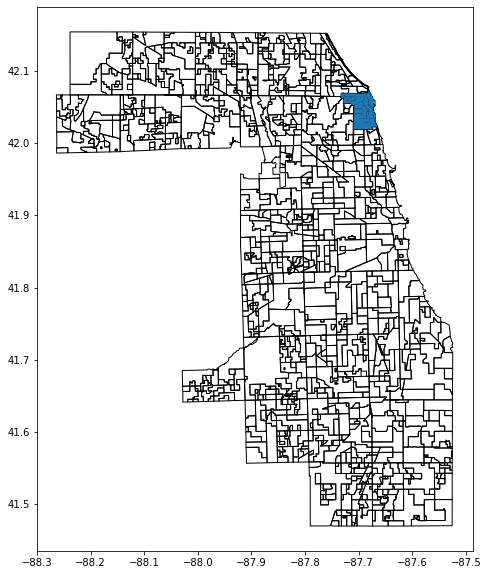

In [57]:
fig, ax = plt.subplots(figsize=(10,10))

ax = neighborhoods_gdf.plot(color="none", ax=ax)
ax = neighborhoods_gdf.loc[neighborhoods_gdf["township_n"] == "Evanston"].plot(ax=ax)

In [58]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "27"),
#     (cc_res_prop_char_df["Property Address"].str.contains("OAK PARK")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(4934, 5)

In [59]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "27"),
#     (cc_res_prop_char_df["Property Address"].str.contains("OAK PARK")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(6451, 5)

In [60]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(24, 5)

In [61]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(14, 5)

In [62]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Central Air
371320,42.039786,-87.670791,1214 LAKE SHORE BLVD EVANSTON,8113,1
371321,42.039637,-87.670882,1212 LAKE SHORE BLVD EVANSTON,10415,1
371458,42.038932,-87.670953,1140 LAKE SHORE BLVD EVANSTON,17500,1
371459,42.038684,-87.670956,1136 LAKE SHORE BLVD EVANSTON,14175,1
371460,42.038448,-87.670959,1130 LAKE SHORE BLVD EVANSTON,15750,1
371461,42.038448,-87.670959,1130 LAKE SHORE BLVD EVANSTON,15750,1
371462,42.038201,-87.670963,1120 LAKE SHORE BLVD EVANSTON,15750,1
371464,42.037957,-87.670966,1114 LAKE SHORE BLVD EVANSTON,15313,1
371838,42.03729,-87.671115,1044 LAKE SHORE BLVD EVANSTON,10154,1
371842,42.036094,-87.671068,1012 LAKE SHORE BLVD EVANSTON,18300,1


In [63]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Central Air
371463,42.038201,-87.670963,1120 LAKE SHORE BLVD EVANSTON,15750,0
371465,42.037957,-87.670966,1114 LAKE SHORE BLVD EVANSTON,15313,0
371839,42.037093,-87.671107,1040 LAKE SHORE BLVD EVANSTON,11775,0
371840,42.03637,-87.671079,1020 LAKE SHORE BLVD EVANSTON,17600,0
371841,42.03637,-87.671079,1020 LAKE SHORE BLVD EVANSTON,17600,0
371843,42.035819,-87.671057,1000 LAKE SHORE BLVD EVANSTON,19000,0
371847,42.036586,-87.671087,1024 LAKE SHORE BLVD EVANSTON,9352,0
795607,42.038201,-87.670963,1120 LAKE SHORE BLVD,15750,0
795609,42.037957,-87.670966,1114 LAKE SHORE BLVD,15313,0
795975,42.037093,-87.671107,1040 LAKE SHORE BLVD,11775,0


It's kind of hard to be certain as I wasn't able to make out external AC radiators, but based on a lot of inspection, wealthier looking streets tend to have values of **1**, so I'm going to assume **0** corresponds with a no here, despite the mapping provided on the data description page.

These Evenston properties on Lake Shore Blvd make me pretty confident.

In [161]:
def clean_cc_residential_prop_chars_central_air_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Central Air"] = df["Central Air"].astype("boolean")
    return df

In [64]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_central_air_col(cc_res_prop_char_df)

In [65]:
cc_res_prop_char_df["Central Air"].value_counts(dropna=False)

True     723431
False    669622
NaN      602055
Name: Central Air, dtype: Int64

### Fireplaces
* Number of fireplaces, counted as the number of flues one can see from the outside of the building.

In [66]:
cc_res_prop_char_df["Fireplaces"].value_counts(dropna=False)

1      916047
NaN    602017
2      320878
0      156166
Name: Fireplaces, dtype: Int64

In [67]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_fireplaces_col(cc_res_prop_char_df)

In [68]:
cc_res_prop_char_df["Fireplaces"].value_counts(dropna=False)

1      916047
NaN    602017
2      320878
0      156166
Name: Fireplaces, dtype: Int64

### Attic Type
* Type of attic - 1 = Full, 2 = partial, 3 = none

In [69]:
cc_res_prop_char_df["Attic Type"].value_counts(dropna=False)

3      961414
NaN    602055
1      242798
2      188841
Name: Attic Type, dtype: Int64

In [70]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_attic_type_col(cc_res_prop_char_df)

In [71]:
cc_res_prop_char_df["Attic Type"].value_counts(dropna=False)

None       961414
NaN        602055
Full       242798
Partial    188841
Name: Attic Type, dtype: int64

### Attic Finish
* Finish of attic - 1 = Living area, 2 = Apartment, 3 = unfinished

In [72]:
cc_res_prop_char_df["Attic Finish"].value_counts(dropna=False)

0      1230003
NaN     333393
3       259763
1       163961
2         7988
Name: Attic Finish, dtype: Int64

In [73]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Attic Finish"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(50)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class
182873,42.061574,-87.699433,1904 LINCOLN ST,296,201
183001,42.061573,-87.699393,1904 LINCOLN ST,296,201
183014,42.061573,-87.699344,1904 LINCOLN ST,433,201
183113,42.059336,-87.70305,2303 HARTREY AVE,6900,241
183215,42.060469,-87.699161,1904 COLFAX ST,20000,299
191321,42.049394,-87.685331,1720 MAPLE AVE,66060,299
206843,42.050673,-87.682753,800 ELGIN RD,98880,299
245832,42.050673,-87.682753,800 ELGIN AVE,98880,299
300880,42.045862,-87.687177,1101 GROVE ST,9127,299
300918,42.045862,-87.687177,1107 GROVE ST,9127,299


I think **0** means "no attic", so I'll go with that.

In [74]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_attic_finish_col(cc_res_prop_char_df)

In [75]:
cc_res_prop_char_df["Attic Finish"].value_counts(dropna=False)

No Attic       1230003
NaN             333393
Unfinished      259763
Living Area     163961
Apartment         7988
Name: Attic Finish, dtype: int64

### Half Baths
* Number of half baths, defined as bathrooms without a shower or bathtub. 

In [76]:
cc_res_prop_char_df["Half Baths"].value_counts(dropna=False)

0      731535
1      623460
NaN    602017
2       33459
3        3190
4         708
6         387
5         329
8          10
7          10
9           3
Name: Half Baths, dtype: Int64

In [77]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_half_baths_col(cc_res_prop_char_df)

In [78]:
cc_res_prop_char_df["Half Baths"].value_counts(dropna=False)

0      731535
1      623460
NaN    602017
2       33459
3        3190
4         708
6         387
5         329
8          10
7          10
9           3
Name: Half Baths, dtype: Int64

### Design Plan
* Plan of Design - 1 = architect, 2 = stock plan

In [79]:
cc_res_prop_char_df["Design Plan"].value_counts(dropna=False)

2      998139
NaN    602017
0      364620
1       30332
Name: Design Plan, dtype: Int64

In [80]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Design Plan"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(50)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class
154614,42.068409,-87.731297,2757 MEADOWLARK LN EVANSTON,5579,234
154620,42.06794,-87.730702,2750 CRAWFORD AVE EVANSTON,5610,234
154624,42.068015,-87.731606,2743 PRINCETON AVE EVANSTON,5959,234
154643,42.068023,-87.724332,3233 OTTO LN EVANSTON,3288,207
154706,42.065698,-87.730395,3603 HILLSIDE RD EVANSTON,6580,234
154708,42.065843,-87.730818,3611 HILLSIDE RD EVANSTON,6486,234
154719,42.065247,-87.729609,3522 HILLSIDE RD EVANSTON,6696,234
154721,42.065246,-87.7292,3516 HILLSIDE RD EVANSTON,5869,234
154775,42.066625,-87.727252,3425 PARK PL EVANSTON,4600,204
155409,42.068422,-87.720078,2745 LAWNDALE AVE EVANSTON,12150,205


In [189]:
def clean_cc_residential_prop_chars_design_plan_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    design_plan_map = {
        0: "Unknown",
        1: "Architect",
        2: "Stock Plan"
    }
    if "Stock Plan" not in df["Design Plan"].unique():
        df["Design Plan"] = df["Design Plan"].map(design_plan_map)
    df["Design Plan"] = df["Design Plan"].astype("category")
    return df

In [81]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_design_plan_col(cc_res_prop_char_df)

In [82]:
cc_res_prop_char_df["Design Plan"].value_counts(dropna=False)

Stock Plan    998139
NaN           602017
Unknown       364620
Architect      30332
Name: Design Plan, dtype: int64

### Cathedral Ceiling
* Cathedral Ceiling - 1 = yes, 2 = No. (Note: the column name comes from a variable that is no longer used, but the column name was not changed to reflect Cathedral Ceiling)

In [83]:
cc_res_prop_char_df["Cathedral Ceiling"].value_counts(dropna=False)

0      724701
2      612327
NaN    602017
1       56063
Name: Cathedral Ceiling, dtype: Int64

In [87]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Cathedral Ceiling"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(30)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class
154581,42.068233,-87.72999,2747 CRAWFORD AVE EVANSTON,2850,234
154582,42.068173,-87.729942,2747 CRAWFORD AVE EVANSTON,2850,234
154592,42.069169,-87.729808,3612 GLENVIEW RD EVANSTON,5280,202
154593,42.069185,-87.729661,3608 GLENVIEW RD EVANSTON,5760,203
154599,42.068324,-87.730061,2753 CRAWFORD AVE EVANSTON,5700,234
154600,42.068444,-87.730157,2757 CRAWFORD AVE EVANSTON,5700,234
154604,42.069035,-87.728748,2773 BERNARD PL EVANSTON,5280,203
154605,42.068925,-87.728749,2767 BERNARD PL EVANSTON,5280,204
154606,42.068816,-87.728751,2767 BERNARD PL EVANSTON,5280,204
154613,42.068504,-87.728358,3433 CLIFFORD ST EVANSTON,12408,278


Ok, **1**s seem mostly (per small sample inspected) to be "Yes", and **2**s seem mostly (per small inspected sample) seem to be **No**, and **0**s seem like **Probably not**? I'll go with unknown.

In [88]:
def clean_cc_residential_prop_chars_cathedral_ceiling_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    attic_finish_map = {
        0: "Unknown",
        1: "Yes",
        2: "No"
    }
    if "Yes" not in df["Cathedral Ceiling"].unique():
        df["Cathedral Ceiling"] = df["Cathedral Ceiling"].map(attic_finish_map)
    df["Cathedral Ceiling"] = df["Cathedral Ceiling"].astype("category")
    return df

In [89]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_cathedral_ceiling_col(cc_res_prop_char_df)

In [90]:
cc_res_prop_char_df["Cathedral Ceiling"].value_counts(dropna=False)

Unknown    724701
No         612327
NaN        602017
Yes         56063
Name: Cathedral Ceiling, dtype: int64

### Construction Quality
* Construction quality - 1 = Deluxe, 2 = Average, 3 = Poor (There is one 4 in this dataset, but no 3. In general, this column is not useful for analytical purposes)

In [91]:
cc_res_prop_char_df["Construction Quality"].value_counts(dropna=False)

2      1373761
NaN     602055
1        18274
4         1017
3            1
Name: Construction Quality, dtype: Int64

In [92]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Construction Quality"] == 3),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(30)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class
516561,42.138573,-87.805517,1018 DUNDEE RD,52620,206


That property looks way too nice to have poor construction quality.

In [93]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Construction Quality"] == 4),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(30)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class
271,42.149432,-88.138671,205 COOLIDGE AVE BARRINGTON,7950,202
688,42.150036,-88.123265,311 S GLENDALE AVE BARRINGTON,17340,203
990,42.144465,-88.135593,803 S HOUGH ST BARRINGTON,10110,203
996,42.143006,-88.135602,845 S HOUGH ST BARRINGTON,10108,203
1079,42.141739,-88.132453,917 S GROVE AVE BARRINGTON,13875,203
1849,42.150979,-88.174323,9 BRINKER RD BARRINGTON HILLS,258929,209
2213,42.134483,-88.193083,339 SUTTON RD BARRINGTON HILLS,218044,202
3523,42.109571,-88.184897,14 CREEKSIDE LN BARRINGTON HILLS,310879,278
3549,42.096272,-88.18998,193 PENNY RD BARRINGTON HILLS,127413,202
10433,42.140321,-88.031553,486 E DUNDEE RD PALATINE,37244,202


Places with `Construction Quality` == 4 look fine. I have no idea what causes these bad values.

In [94]:
def clean_cc_residential_prop_chars_construction_quality_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    construction_quality_map = {
        1: "Deluxe",
        2: "Average",
        3: "Unknown",
        4: "Unknown"
    }
    if "Deluxe" not in df["Construction Quality"].unique():
        df["Construction Quality"] = df["Construction Quality"].map(construction_quality_map)
    df["Construction Quality"] = df["Construction Quality"].astype("category")
    return df

In [95]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_construction_quality_col(cc_res_prop_char_df)

In [96]:
cc_res_prop_char_df["Construction Quality"].value_counts(dropna=False)

Average    1373761
NaN         602055
Deluxe       18274
Unknown       1018
Name: Construction Quality, dtype: int64

### Renovation
* Construction renovation - 1 = yes, 2= no

In [98]:
cc_res_prop_char_df["Renovation"].value_counts(dropna=False)

NaN    1992944
yes       2041
no         123
Name: Renovation, dtype: int64

In [97]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_renovation_col(cc_res_prop_char_df)

In [99]:
cc_res_prop_char_df["Renovation"].value_counts(dropna=False)

NaN    1992944
yes       2041
no         123
Name: Renovation, dtype: int64

### Site Desireability
* Site desireability - 1 = Beneficial to Value, 2 = Not relevant to Value, 3 = Detracts from Value. This field lack sufficient variation to be useful for modeling.

In [100]:
cc_res_prop_char_df["Site Desireability"].value_counts(dropna=False)

2      1383432
NaN     602055
1         7369
3         2252
Name: Site Desireability, dtype: Int64

In [101]:
def clean_cc_residential_prop_chars_site_desireability_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    site_desireability_map = {
        1: "Beneficial to Value",
        2: "Not relevant to Value",
        3: "Detracts from Value"
    }
    if "Not relevant to Value" not in df["Site Desireability"].unique():
        df["Site Desireability"] = df["Site Desireability"].map(
            site_desireability_map
        )
    df["Site Desireability"] = df["Site Desireability"].astype("category")
    return df

In [102]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_site_desireability_col(cc_res_prop_char_df)

In [103]:
cc_res_prop_char_df["Site Desireability"].value_counts(dropna=False)

Not relevant to Value    1383432
NaN                       602055
Beneficial to Value         7369
Detracts from Value         2252
Name: Site Desireability, dtype: int64

### Garage 1 Size
* Garage 1 size - 1 = 1 car, 2 = 1.5 car, 3 = 2 car, 4 = 2.5 cars, 5 = 3 cars, 6 = 3.5 cars, 7 = none, 8 = 4 cars

In [105]:
cc_res_prop_char_df["Garage 1 Size"].value_counts(dropna=False)

3      772368
NaN    602017
0      215906
1      201022
2       76534
4       64362
5       49220
7        7395
6        4984
10        971
11        171
12         87
9          43
15         12
13          9
16          4
14          3
Name: Garage 1 Size, dtype: Int64

In [107]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Size"] >= 9) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class,Garage 1 Size
154598,42.068565,-87.730253,2759 CRAWFORD AVE EVANSTON,5700,234,9
154866,42.065738,-87.722866,3201 HARTZELL ST EVANSTON,5108,205,10
154902,42.065242,-87.725381,3256 HARTZELL ST EVANSTON,6250,204,11
154932,42.064859,-87.725158,3253 CENTRAL ST EVANSTON,3000,295,10
155393,42.06858,-87.721215,2746 LAWNDALE AVE EVANSTON,12150,206,10
155597,42.066901,-87.720287,2667 LAWNDALE AVE EVANSTON,5600,205,10
155598,42.066791,-87.720288,2663 LAWNDALE AVE EVANSTON,5600,205,10
155616,42.066713,-87.719276,3031 PARK PL EVANSTON,5680,203,10
155624,42.067204,-87.718137,2708 CENTRAL ST EVANSTON,3750,202,10
155703,42.06607,-87.716157,2645 HURD AVE EVANSTON,6850,206,11


Nope. I spot checked ~10 and they're all small houses with regular garages. 

In [108]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Size"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class,Garage 1 Size
154581,42.068233,-87.72999,2747 CRAWFORD AVE EVANSTON,2850,234,0
154582,42.068173,-87.729942,2747 CRAWFORD AVE EVANSTON,2850,234,0
154583,42.068112,-87.729894,3465 CLIFFORD ST EVANSTON,2850,234,0
154584,42.068052,-87.729846,3465 CLIFFORD ST EVANSTON,2850,234,0
154599,42.068324,-87.730061,2753 CRAWFORD AVE EVANSTON,5700,234,0
154602,42.068954,-87.730562,2771 CRAWFORD AVE EVANSTON,6606,234,0
154613,42.068504,-87.728358,3433 CLIFFORD ST EVANSTON,12408,278,0
154616,42.06799,-87.731165,2743 MEADOWLARK LN EVANSTON,6840,234,0
154618,42.068247,-87.730862,2760 CRAWFORD AVE EVANSTON,6408,234,0
154619,42.068084,-87.730758,2754 CRAWFORD AVE EVANSTON,5985,234,0


**0**s appear to indicate **no garage** or **car port**.

In [ ]:
garage_size_map = {
    0: "Car Port or Driveway Only",
    1: "1 car",
    2: "1.5 car",
    3: "2 car",
    4: "2.5 cars",
    5: "3 cars",
    6: "3.5 cars",
    7: "None",
    8: "4 cars"
}

In [111]:
def get_garage_size_map() -> Dict:
    garage_size_map = {
        0: "Car Port or Driveway Only",
        1: "1 car",
        2: "1.5 car",
        3: "2 car",
        4: "2.5 cars",
        5: "3 cars",
        6: "3.5 cars",
        7: "None",
        8: "4 cars",
        9: "Unknown"
    }
    return garage_size_map

In [114]:
def clean_cc_residential_prop_chars_garage_1_size_col(
    df: pd.DataFrame, 
) -> pd.DataFrame:
    garage_size_map = get_garage_size_map()
    bad_garage_size_value_mask = (df["Garage 1 Size"] >= 9) 
    df.loc[bad_garage_size_value_mask, "Garage 1 Size"] = 9
    if "1 car" not in df["Garage 1 Size"].unique():
        df["Garage 1 Size"] = df["Garage 1 Size"].map(garage_size_map)
    df["Garage 1 Size"] = df["Garage 1 Size"].astype("category")
    return df

In [115]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_1_size_col(cc_res_prop_char_df)

In [116]:
cc_res_prop_char_df["Garage 1 Size"].value_counts(dropna=False)

2 car                        772368
NaN                          602017
Car Port or Driveway Only    215906
1 car                        201022
1.5 car                       76534
2.5 cars                      64362
3 cars                        49220
None                           7395
3.5 cars                       4984
Unknown                        1300
Name: Garage 1 Size, dtype: int64

### Garage 2 Size
* Garage 1 size - 1 = 1 car, 2 = 1.5 car, 3 = 2 car, 4 = 2.5 cars, 5 = 3 cars, 6 = 3.5 cars, 7 = none, 8 = 4 cars

In [125]:
cc_res_prop_char_df["Garage 2 Size"].value_counts(dropna=False)

7      1392257
NaN     602017
3          353
1          309
2           74
4           51
6           27
5           20
Name: Garage 2 Size, dtype: Int64

In [127]:
def clean_cc_residential_prop_chars_garage_size_col(
    df: pd.DataFrame, garage_num: str = "1"
) -> pd.DataFrame:
    garage_size_map = get_garage_size_map()
    bad_garage_size_value_mask = df[f"Garage {garage_num} Size"] >= 9
    df.loc[bad_garage_size_value_mask, f"Garage {garage_num} Size"] = 9
    if "1 car" not in df[f"Garage {garage_num} Size"].unique():
        df[f"Garage {garage_num} Size"] = df[f"Garage {garage_num} Size"].map(garage_size_map)
    df[f"Garage {garage_num} Size"] = df[f"Garage {garage_num} Size"].astype("category")
    return df

In [128]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_size_col(cc_res_prop_char_df, "2")

In [129]:
cc_res_prop_char_df["Garage 2 Size"].value_counts(dropna=False)

None        1392257
NaN          602017
2 car           353
1 car           309
1.5 car          74
2.5 cars         51
3.5 cars         27
3 cars           20
Name: Garage 2 Size, dtype: int64

### Garage 1 Material
* Garage 1 construction - 1 = Frame, 2 = Masonry, 3= Frame/Masonry, 4 = Stucco

In [117]:
cc_res_prop_char_df["Garage 1 Material"].value_counts(dropna=False)

1      790068
NaN    602016
2      299082
0      215893
3       83681
4        4368
Name: Garage 1 Material, dtype: Int64

In [120]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Material"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class,Garage 1 Size
154581,42.068233,-87.72999,2747 CRAWFORD AVE EVANSTON,2850,234,Car Port or Driveway Only
154582,42.068173,-87.729942,2747 CRAWFORD AVE EVANSTON,2850,234,Car Port or Driveway Only
154583,42.068112,-87.729894,3465 CLIFFORD ST EVANSTON,2850,234,Car Port or Driveway Only
154584,42.068052,-87.729846,3465 CLIFFORD ST EVANSTON,2850,234,Car Port or Driveway Only
154599,42.068324,-87.730061,2753 CRAWFORD AVE EVANSTON,5700,234,Car Port or Driveway Only
154602,42.068954,-87.730562,2771 CRAWFORD AVE EVANSTON,6606,234,Car Port or Driveway Only
154613,42.068504,-87.728358,3433 CLIFFORD ST EVANSTON,12408,278,Car Port or Driveway Only
154616,42.06799,-87.731165,2743 MEADOWLARK LN EVANSTON,6840,234,Car Port or Driveway Only
154618,42.068247,-87.730862,2760 CRAWFORD AVE EVANSTON,6408,234,Car Port or Driveway Only
154619,42.068084,-87.730758,2754 CRAWFORD AVE EVANSTON,5985,234,Car Port or Driveway Only


In [121]:
def get_garage_material_map() -> Dict:
    garage_material_map = {
        0: "Car Port or Driveway Only",
        1: "Frame",
        2: "Masonry",
        3: "Frame/Masonry",
        4: "Stucco"
    }
    return garage_material_map

In [130]:
def clean_cc_residential_prop_chars_garage_material_col(
    df: pd.DataFrame, garage_num: str = "1"
) -> pd.DataFrame:
    garage_material_map = get_garage_material_map()
    if "Frame" not in df[f"Garage {garage_num} Material"].unique():
        df[f"Garage {garage_num} Material"] = df[f"Garage {garage_num} Material"].map(garage_material_map)
    df[f"Garage {garage_num} Material"] = df[f"Garage {garage_num} Material"].astype("category")
    return df

In [123]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_material_col(cc_res_prop_char_df, "1")

In [124]:
cc_res_prop_char_df["Garage 1 Material"].value_counts(dropna=False)

Frame                        790068
NaN                          602016
Masonry                      299082
Car Port or Driveway Only    215893
Frame/Masonry                 83681
Stucco                         4368
Name: Garage 1 Material, dtype: int64

### Garage 2 Material
* Garage 2 construction - 1 = Frame, 2 = Masonry, 3= Frame/Masonry, 4 = Stucco

In [131]:
cc_res_prop_char_df["Garage 2 Material"].value_counts(dropna=False)

0      1392257
NaN     602017
1          616
2          203
3            9
4            6
Name: Garage 2 Material, dtype: Int64

In [132]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_material_col(cc_res_prop_char_df, "2")

In [133]:
cc_res_prop_char_df["Garage 2 Material"].value_counts(dropna=False)

Car Port or Driveway Only    1392257
NaN                           602017
Frame                            616
Masonry                          203
Frame/Masonry                      9
Stucco                             6
Name: Garage 2 Material, dtype: int64

### Garage 1 Attachment
* Is Garage 1 attached? 1 = Yes, 2 = No

In [134]:
cc_res_prop_char_df["Garage 1 Attachment"].value_counts(dropna=False)

2      683649
NaN    602016
1      493549
0      215894
Name: Garage 1 Attachment, dtype: Int64

In [135]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Attachment"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class,Garage 1 Size
154581,42.068233,-87.72999,2747 CRAWFORD AVE EVANSTON,2850,234,Car Port or Driveway Only
154582,42.068173,-87.729942,2747 CRAWFORD AVE EVANSTON,2850,234,Car Port or Driveway Only
154583,42.068112,-87.729894,3465 CLIFFORD ST EVANSTON,2850,234,Car Port or Driveway Only
154584,42.068052,-87.729846,3465 CLIFFORD ST EVANSTON,2850,234,Car Port or Driveway Only
154599,42.068324,-87.730061,2753 CRAWFORD AVE EVANSTON,5700,234,Car Port or Driveway Only
154602,42.068954,-87.730562,2771 CRAWFORD AVE EVANSTON,6606,234,Car Port or Driveway Only
154613,42.068504,-87.728358,3433 CLIFFORD ST EVANSTON,12408,278,Car Port or Driveway Only
154616,42.06799,-87.731165,2743 MEADOWLARK LN EVANSTON,6840,234,Car Port or Driveway Only
154618,42.068247,-87.730862,2760 CRAWFORD AVE EVANSTON,6408,234,Car Port or Driveway Only
154619,42.068084,-87.730758,2754 CRAWFORD AVE EVANSTON,5985,234,Car Port or Driveway Only


In [136]:
def get_garage_attachment_map() -> Dict:
    garage_attached_map = {
        0: "Car Port or Driveway Only",
        1: "Yes", 
        2: "No"
    }
    return garage_attached_map

In [137]:
def clean_cc_residential_prop_chars_garage_attachment_col(
    df: pd.DataFrame, garage_num: str = "1"
) -> pd.DataFrame:
    garage_attached_map = get_garage_attachment_map()
    if "Frame" not in df[f"Garage {garage_num} Attachment"].unique():
        df[f"Garage {garage_num} Attachment"] = df[
            f"Garage {garage_num} Attachment"
        ].map(garage_attached_map)
    df[f"Garage {garage_num} Attachment"] = df[
        f"Garage {garage_num} Attachment"
    ].astype("category")
    return df

In [138]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_attachment_col(cc_res_prop_char_df, "1")

In [139]:
cc_res_prop_char_df["Garage 1 Attachment"].value_counts(dropna=False)

No                           683649
NaN                          602016
Yes                          493549
Car Port or Driveway Only    215894
Name: Garage 1 Attachment, dtype: int64

### Garage 2 Attachment

In [140]:
cc_res_prop_char_df["Garage 2 Attachment"].value_counts(dropna=False)

0      1392257
NaN     602017
2          608
1          226
Name: Garage 2 Attachment, dtype: Int64

In [141]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_attachment_col(cc_res_prop_char_df, "2")

In [142]:
cc_res_prop_char_df["Garage 2 Attachment"].value_counts(dropna=False)

Car Port or Driveway Only    1392257
NaN                           602017
No                               608
Yes                              226
Name: Garage 2 Attachment, dtype: int64

### Garage 1 Area
* Is Garage 1 physically including within the building area? 1 = Yes, 2 = No. If yes, the garage area is subtracted from the building square feet calculation by the field agent. 

In [144]:
cc_res_prop_char_df["Garage 1 Area"].value_counts(dropna=False)

2      1037746
NaN     602016
0       215898
1       139448
Name: Garage 1 Area, dtype: Int64

In [145]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Area"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class,Garage 1 Size
154581,42.068233,-87.72999,2747 CRAWFORD AVE EVANSTON,2850,234,Car Port or Driveway Only
154582,42.068173,-87.729942,2747 CRAWFORD AVE EVANSTON,2850,234,Car Port or Driveway Only
154583,42.068112,-87.729894,3465 CLIFFORD ST EVANSTON,2850,234,Car Port or Driveway Only
154584,42.068052,-87.729846,3465 CLIFFORD ST EVANSTON,2850,234,Car Port or Driveway Only
154599,42.068324,-87.730061,2753 CRAWFORD AVE EVANSTON,5700,234,Car Port or Driveway Only
154602,42.068954,-87.730562,2771 CRAWFORD AVE EVANSTON,6606,234,Car Port or Driveway Only
154613,42.068504,-87.728358,3433 CLIFFORD ST EVANSTON,12408,278,Car Port or Driveway Only
154616,42.06799,-87.731165,2743 MEADOWLARK LN EVANSTON,6840,234,Car Port or Driveway Only
154618,42.068247,-87.730862,2760 CRAWFORD AVE EVANSTON,6408,234,Car Port or Driveway Only
154619,42.068084,-87.730758,2754 CRAWFORD AVE EVANSTON,5985,234,Car Port or Driveway Only


In [147]:
def get_garage_area_map() -> Dict:
    garage_area_map = {
        0: "Car Port or Driveway Only",
        1: "Yes, garage area included in building area", 
        2: "No, garage area not included in building area"
    }
    return garage_area_map

In [148]:
def clean_cc_residential_prop_chars_garage_area_col(
    df: pd.DataFrame, garage_num: str = "1"
) -> pd.DataFrame:
    garage_area_map = get_garage_area_map()
    if "Frame" not in df[f"Garage {garage_num} Area"].unique():
        df[f"Garage {garage_num} Area"] = df[
            f"Garage {garage_num} Area"
        ].map(garage_area_map)
    df[f"Garage {garage_num} Area"] = df[
        f"Garage {garage_num} Area"
    ].astype("category")
    return df

In [149]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_area_col(cc_res_prop_char_df, "1")

In [150]:
cc_res_prop_char_df["Garage 1 Area"].value_counts(dropna=False)

No, garage area not included in building area    1037746
NaN                                               602016
Car Port or Driveway Only                         215898
Yes, garage area included in building area        139448
Name: Garage 1 Area, dtype: int64

### Garage 2 Area
* Is Garage 2 physically including within the building area? 1 = Yes, 2 = No. If yes, the garage area is subtracted from the building square feet calculation by the field agent. 

In [151]:
cc_res_prop_char_df["Garage 2 Area"].value_counts(dropna=False)

0      1391403
NaN     602017
4          855
2          607
1          226
Name: Garage 2 Area, dtype: Int64

In [152]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_area_col(cc_res_prop_char_df, "2")

In [153]:
cc_res_prop_char_df["Garage 2 Area"].value_counts(dropna=False)

Car Port or Driveway Only                        1391403
NaN                                               602872
No, garage area not included in building area        607
Yes, garage area included in building area           226
Name: Garage 2 Area, dtype: int64

### Porch
* Enclosed porch - 1 = Frame, 2 = Masonry, 3 = None 

In [154]:
cc_res_prop_char_df["Porch"].value_counts(dropna=False)

3      1767801
1       209401
2        17906
NaN          0
Name: Porch, dtype: Int64

In [ ]:
porch_map = {
    1: "Frame",
    2: "Masonry",
    3: "None"
}

In [155]:
def clean_cc_residential_prop_chars_porch_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    porch_map = {
        1: "Frame",
        2: "Masonry",
        3: "None"
    }
    if "None" not in df["Porch"].unique():
        df["Porch"] = df["Porch"].map(
            porch_map
        )
    df["Porch"] = df["Porch"].astype("category")
    return df

In [157]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_porch_col(cc_res_prop_char_df)

In [158]:
cc_res_prop_char_df["Porch"].value_counts(dropna=False)

None       1767801
Frame       209401
Masonry      17906
Name: Porch, dtype: int64

### Other Improvements
* Other improvements - if not 0, they contain a code. The definitions of these codes are maintained by the field workers. Unfortunately, the way this data is entered makes it impossible to distinguish between a 1 & 2 and a 12, making this field mostly useless.

In [159]:
cc_res_prop_char_df["Other Improvements"].value_counts(dropna=False)

0        1341530
NaN       602017
76           748
192          629
64           572
          ...   
24087          1
1559           1
1453           1
1556           1
51625          1
Name: Other Improvements, Length: 1936, dtype: Int64

Whelp, considering the note from the data documentation, I don't think this column will be useful.

### Building Square Feet
* Building square feet, as measured from the exterior of the property

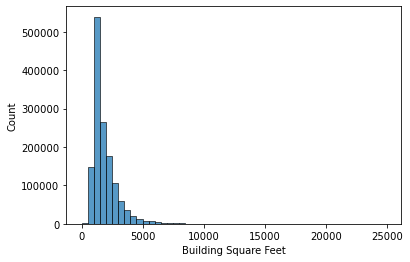

In [160]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Building Square Feet", bins=50)

(0.0, 10000.0)

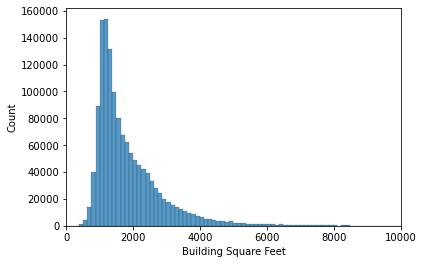

In [162]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Building Square Feet", bins=200)
ax.set_xlim(0, 10000)

(0.0, 4000.0)

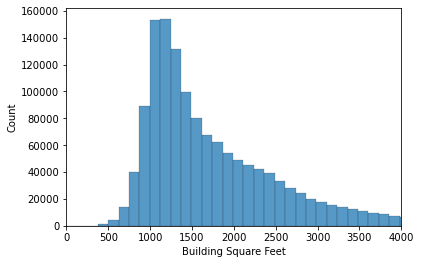

In [164]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Building Square Feet", bins=200)
ax.set_xlim(0, 4000)

In [165]:
cc_res_prop_char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995108 entries, 0 to 1995107
Data columns (total 83 columns):
 #   Column                                           Dtype   
---  ------                                           -----   
 0   PIN                                              Int64   
 1   Property Class                                   category
 2   Tax Year                                         Int64   
 3   Neighborhood Code                                category
 4   Land Square Feet                                 Int64   
 5   Town Code                                        category
 6   Type of Residence                                category
 7   Apartments                                       Int8    
 8   Wall Material                                    category
 9   Roof Material                                    category
 10  Rooms                                            Int8    
 11  Bedrooms                                         Int8    
 12  

### Repair Condition
* State of Repair - 1 = Above average, 2 = Average, 3 = Below average

In [166]:
cc_res_prop_char_df["Repair Condition"].value_counts(dropna=False)

2      1370862
NaN     602055
1        14926
3         7265
Name: Repair Condition, dtype: Int64

In [168]:
def clean_cc_residential_prop_chars_repair_condition_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    state_of_repair_map = {
        1: "Above average",
        2: "Average",
        3: "Below average"
    }
    if "Average" not in df["Repair Condition"].unique():
        df["Repair Condition"] = df["Repair Condition"].map(
            state_of_repair_map
        )
    df["Repair Condition"] = df["Repair Condition"].astype("category")
    return df

In [169]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_repair_condition_col(cc_res_prop_char_df)

In [170]:
cc_res_prop_char_df["Repair Condition"].value_counts(dropna=False)

Average          1370862
NaN               602055
Above average      14926
Below average       7265
Name: Repair Condition, dtype: int64

### Multi Code
* Variable that indicates that more one building exists on the PIN. 2 = one building, 3 = two buildings, etc… through 7 = 6 buildings. 

In [173]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Multi Code"] > 10),
    ["PIN", "Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Multi Code"]
].drop_duplicates().head(30)

,PIN,Latitude,Longitude,Property Address,Land Square Feet,Property Class,Multi Code
126047,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,17
126048,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,18
126049,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,19
126050,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,20
126051,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,21
126052,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,22
126062,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,11
126063,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,12
126064,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,13
126065,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,14


For units with high `Multi Code` values, it looks kind of like they're mainly subdivisions and apartment blocks that were incorrectly entered, with some centralized address used and `Multi Code` to identify buildings. This is kind of irritating as it will impact these properties, but on the other hand, it's not that many. 

In [176]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Multi Code"] == 7),
    ["PIN", "Latitude", "Longitude", "Property Address", 
     "Land Square Feet", "Property Class", "Multi Code"]
].drop_duplicates().head(30)

,PIN,Latitude,Longitude,Property Address,Land Square Feet,Property Class,Multi Code
126058,4274160230000,42.081715,-87.817912,2501 INDIGO LN GLENVIEW,192668,204,7
126203,4274280020000,42.079813,-87.816821,2501 INDIGO LN GLENVIEW,101028,295,7
126214,4274280040000,42.082009,-87.815081,2301 INDIGO LN GLENVIEW,103124,295,7
126437,4282020180000,42.093996,-87.83252,2164 CORAL LN GLENVIEW,9129,295,7
126443,4282020190000,42.093998,-87.832901,2169 DAUNTLESS DR GLENVIEW,9129,295,7
126637,4282070400000,42.090971,-87.832551,1993 DANTLESS DR GLENVIEW,16456,295,7
126680,4282080040000,42.092492,-87.832518,2101 DAUNTLESS DR GLENVIEW,16250,295,7
126686,4282080050000,42.093017,-87.832496,2125 DAUNTLESS DR GLENVIEW,16132,295,7
126690,4282080060000,42.093643,-87.83125,2176 SHERMER RD GLENVIEW,17492,295,7
126702,4282080090000,42.092487,-87.832016,2102 SHERMER RD GLENVIEW,16761,295,7


In [171]:
cc_res_prop_char_df["Multi Code"].value_counts(dropna=False)

2      1372913
NaN     602017
3        18803
4          717
5          230
6           98
7           63
8           32
9           25
10          21
11          13
12          11
13          10
14           8
21           7
17           7
16           7
15           7
18           7
19           7
20           7
22           6
36           4
34           4
35           4
37           4
38           4
39           4
40           4
41           4
42           4
43           4
27           4
24           4
23           4
32           4
31           4
30           4
33           4
28           4
25           4
29           4
26           4
46           2
45           2
44           2
47           2
Name: Multi Code, dtype: Int64

In [ ]:
number_of_buildings_map = {
    2: "One building",
    3: "Two buildings",
    4: "Three buildings",
    5: "Four buildings",
    6: "Five buildings",
    7: "Six buildings",
    8: "Bad Value Entered"
}

In [179]:
def clean_cc_residential_prop_chars_multi_code_col(
    df: pd.DataFrame
) -> pd.DataFrame:
    number_of_buildings_map = {
        2: "One building",
        3: "Two buildings",
        4: "Three buildings",
        5: "Four buildings",
        6: "Five buildings",
        7: "Six buildings",
        8: "Bad Value Entered"
    }
    bad_multi_code_value_mask = df["Multi Code"] >= 8
    df.loc[bad_multi_code_value_mask, "Multi Code"] = 9
    if "One building" not in df["Multi Code"].unique():
        df["Multi Code"] = df["Multi Code"].map(
            number_of_buildings_map
        )
    df["Multi Code"] = df["Multi Code"].astype("category")
    return df

In [180]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_multi_code_col(cc_res_prop_char_df)

In [181]:
cc_res_prop_char_df["Multi Code"].value_counts(dropna=False)

One building       1372913
NaN                 602284
Two buildings        18803
Three buildings        717
Four buildings         230
Five buildings          98
Six buildings           63
Name: Multi Code, dtype: int64

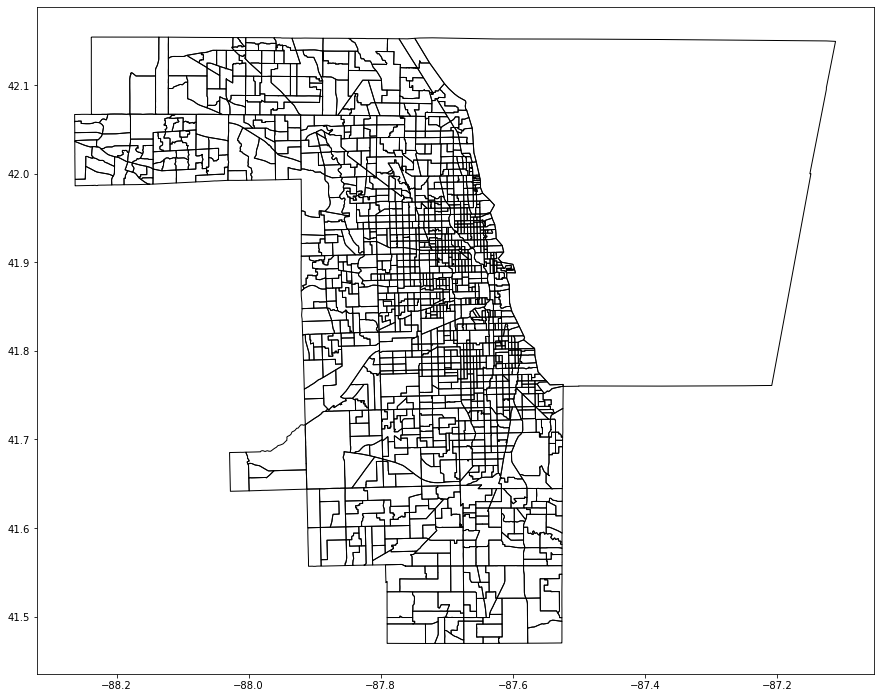

In [280]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cook_county_census_tract_2020_gdf.plot(color="none", ax=ax)

In [284]:
cook_county_census_tract_2010_gdf = get_2010_cook_county_census_tract_gdf()
cook_county_census_tract_2010_gdf.shape

(1319, 13)

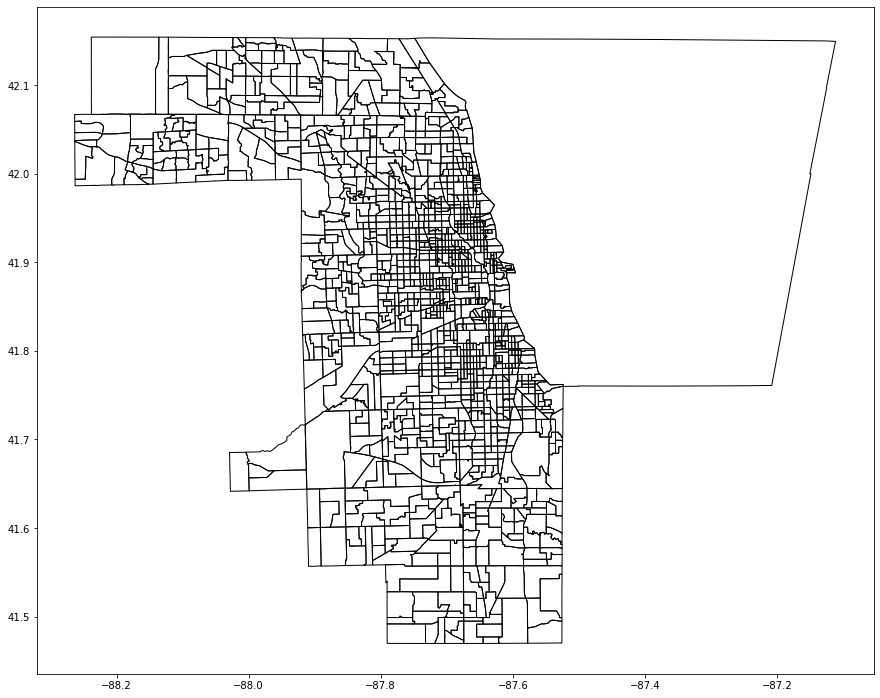

In [285]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cook_county_census_tract_2010_gdf.plot(color="none", ax=ax)

In [287]:
gdf.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr,geometry
0,1011000040000,212,2018,012,11055,10,two story,5,Wood,Tar and Gravel,7,5,Partial,Unfinished,Warm air,none,False,0,Full,Unfinished,1,Stock Plan,No,Average,NaN,Not relevant to Value,1.5 car,Frame,No,"No, garage area not included in building area",None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,200,1904,Average,One building,1,52510,374930,NaT,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,0,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,<NA>,212,0,<NA>,<NA>,0,0,1,1,<NA>,18225,13.5,182.25,122213025,3625216,2.084499,1,<NA>,0,0,12,105.14276,11.61895,43.634848,1012,mixed_use_bldg_w_lte_6_units__any_age__gte_20k...,POINT (-88.13962 42.15395)
1,1011000050000,205,2018,012,6534,10,two story,0,Wood,Shingle/Asphalt,7,4,Full,Unfinished,Hot water steam,none,False,1,Full,Unfinished,0,Stock Plan,No,Average,NaN,Not relevant to Value,2 car,Frame,No,"No, garage area not included in building area",None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,Frame,0,1562,Average,One building,0,31030,173970,NaT,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,0,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,12996,11.4,129.96,42693156,2439844,2.079861,1,<NA>,0,0,12,80.833162,10.677078,39.522146,1012,two_plus_story_residence__gt_62_yrs_old__lt_22...,POINT (-88.13938 42.15395)


In [290]:
evanston_gdf = gdf.loc[(gdf["Town Code"] == "17")].copy()

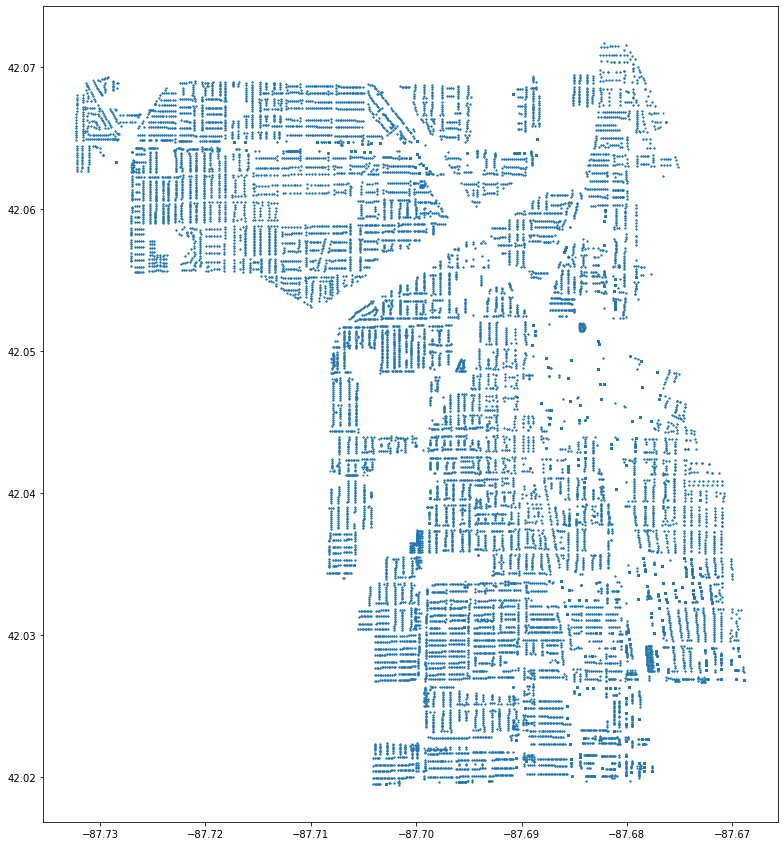

In [291]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = evanston_gdf.plot(markersize=1, ax=ax)

In [292]:
evanston_gdf.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr,geometry
154581,5333030140000,234,2018,011,2850,17,split level,0,Masonry,Shingle/Asphalt,6,3,Partial,Formal rec room,Warm air,none,True,0,None,NaN,0,Stock Plan,Unknown,Average,NaN,Not relevant to Value,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,0,1211,Average,One building,0,25650,175630,NaT,<NA>,<NA>,-87.729990,42.068233,808900,<NA>,0,2747 CRAWFORD AVE EVANSTON,SF,2,58,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,3364,5.8,33.64,8122500,1466521,1.97213,0,<NA>,0,0,11,53.385391,7.615773,34.799425,1711,split_level_residence_w_a_level_below_ground__...,POINT (-87.72999 42.06823)
154582,5333030150000,234,2018,011,2850,17,split level,0,Masonry,Shingle/Asphalt,6,3,Partial,Formal rec room,Warm air,none,True,0,None,NaN,0,Stock Plan,Unknown,Average,NaN,Not relevant to Value,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,0,1211,Average,One building,0,25650,175630,NaT,<NA>,<NA>,-87.729942,42.068173,808900,<NA>,0,2747 CRAWFORD AVE EVANSTON,SF,2,58,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,3364,5.8,33.64,8122500,1466521,1.970337,0,<NA>,0,0,11,53.385391,7.615773,34.799425,1711,split_level_residence_w_a_level_below_ground__...,POINT (-87.72994 42.06817)


In [286]:
cook_county_census_tract_2010_gdf.head(2)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,17,031,010100,17031010100,101,Census Tract,G5020,S,379751,0,+42.0212564,-087.6698316,"POLYGON ((-87.67720 42.02294, -87.67628 42.022..."
1,17,031,010201,17031010201,102.01,Census Tract,G5020,S,504464,0,+42.0160077,-087.6801484,"POLYGON ((-87.68465 42.01948, -87.68432 42.019..."


In [294]:
evanston_gdf["Census Tract"] = evanston_gdf["Census Tract"].astype("string")

In [295]:
merge_gdf = pd.merge(
    left=evanston_gdf,
    right=cook_county_census_tract_2010_gdf,
    how="outer",
    left_on="Census Tract",
    right_on="TRACTCE10"
    
)

In [296]:
merge_gdf.shape

(46017, 97)

In [299]:
merge_gdf.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr,geometry_x,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry_y
0,5333030140000,234,2018,011,2850,17,split level,0,Masonry,Shingle/Asphalt,6,3,Partial,Formal rec room,Warm air,none,True,0,None,NaN,0,Stock Plan,Unknown,Average,NaN,Not relevant to Value,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,0,1211,Average,One building,0,25650,175630,NaT,<NA>,<NA>,-87.729990,42.068233,808900,<NA>,0,2747 CRAWFORD AVE EVANSTON,SF,2,58,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,3364,5.8,33.64,8122500,1466521,1.97213,0,<NA>,0,0,11,53.385391,7.615773,34.799425,1711,split_level_residence_w_a_level_below_ground__...,POINT (-87.72999 42.06823),17,031,808900,17031808900,8089,Census Tract,G5020,S,1433911.0,0.0,+42.0665152,-087.7174711,"POLYGON ((-87.73245 42.06292, -87.73243 42.064..."
1,5333030150000,234,2018,011,2850,17,split level,0,Masonry,Shingle/Asphalt,6,3,Partial,Formal rec room,Warm air,none,True,0,None,NaN,0,Stock Plan,Unknown,Average,NaN,Not relevant to Value,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,0,1211,Average,One building,0,25650,175630,NaT,<NA>,<NA>,-87.729942,42.068173,808900,<NA>,0,2747 CRAWFORD AVE EVANSTON,SF,2,58,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,3364,5.8,33.64,8122500,1466521,1.970337,0,<NA>,0,0,11,53.385391,7.615773,34.799425,1711,split_level_residence_w_a_level_below_ground__...,POINT (-87.72994 42.06817),17,031,808900,17031808900,8089,Census Tract,G5020,S,1433911.0,0.0,+42.0665152,-087.7174711,"POLYGON ((-87.73245 42.06292, -87.73243 42.064..."


In [302]:
cook_county_census_tract_2010_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [306]:
cook_county_census_tract_2010_gdf = cook_county_census_tract_2010_gdf.to_crs(evanston_gdf.crs)

In [312]:
sjoin_gdf = gpd.sjoin(evanston_gdf, cook_county_census_tract_2010_gdf, how="left", op="within")
sjoin_gdf.shape

(44716, 97)

In [313]:
# sjoin_gdf = gpd.sjoin(cook_county_census_tract_2010_gdf, evanston_gdf, how="left", op="within")
# sjoin_gdf.shape

<AxesSubplot:>

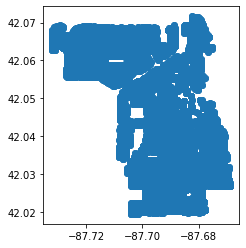

In [314]:
sjoin_gdf.plot()

In [315]:
sjoin_gdf.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr,geometry,index_right,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
154581,5333030140000,234,2018,011,2850,17,split level,0,Masonry,Shingle/Asphalt,6,3,Partial,Formal rec room,Warm air,none,True,0,None,NaN,0,Stock Plan,Unknown,Average,NaN,Not relevant to Value,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,0,1211,Average,One building,0,25650,175630,NaT,<NA>,<NA>,-87.729990,42.068233,808900,<NA>,0,2747 CRAWFORD AVE EVANSTON,SF,2,58,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,3364,5.8,33.64,8122500,1466521,1.97213,0,<NA>,0,0,11,53.385391,7.615773,34.799425,1711,split_level_residence_w_a_level_below_ground__...,POINT (-87.72999 42.06823),891.0,17,031,808900,17031808900,8089,Census Tract,G5020,S,1433911.0,0.0,+42.0665152,-087.7174711
154582,5333030150000,234,2018,011,2850,17,split level,0,Masonry,Shingle/Asphalt,6,3,Partial,Formal rec room,Warm air,none,True,0,None,NaN,0,Stock Plan,Unknown,Average,NaN,Not relevant to Value,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,Car Port or Driveway Only,Car Port or Driveway Only,Car Port or Driveway Only,None,0,1211,Average,One building,0,25650,175630,NaT,<NA>,<NA>,-87.729942,42.068173,808900,<NA>,0,2747 CRAWFORD AVE EVANSTON,SF,2,58,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,3364,5.8,33.64,8122500,1466521,1.970337,0,<NA>,0,0,11,53.385391,7.615773,34.799425,1711,split_level_residence_w_a_level_below_ground__...,POINT (-87.72994 42.06817),891.0,17,031,808900,17031808900,8089,Census Tract,G5020,S,1433911.0,0.0,+42.0665152,-087.7174711


In [317]:
ct_map = sjoin_gdf[["Census Tract", "TRACTCE10", "GEOID10", "NAME10"]].drop_duplicates()
ct_map.shape

(19, 4)

In [318]:
ct_map

,Census Tract,TRACTCE10,GEOID10,NAME10
154581,808900,808900,17031808900,8089
157814,808800,808800,17031808800,8088
182873,809100,809100,17031809100,8091
191321,809400,809400,17031809400,8094
300880,809500,809500,17031809500,8095
305142,810000,810000,17031810000,8100
312032,810200,810200,17031810200,8102
316847,809200,809200,17031809200,8092
317876,809000,809000,17031809000,8090
320862,808702,808702,17031808702,8087.02


In [320]:
cook_county_census_tract_2010_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   1319 non-null   object  
 1   COUNTYFP10  1319 non-null   object  
 2   TRACTCE10   1319 non-null   object  
 3   GEOID10     1319 non-null   object  
 4   NAME10      1319 non-null   object  
 5   NAMELSAD10  1319 non-null   object  
 6   MTFCC10     1319 non-null   object  
 7   FUNCSTAT10  1319 non-null   object  
 8   ALAND10     1319 non-null   int64   
 9   AWATER10    1319 non-null   int64   
 10  INTPTLAT10  1319 non-null   object  
 11  INTPTLON10  1319 non-null   object  
 12  geometry    1319 non-null   geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 134.1+ KB


In [319]:
cc_res_prop_char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995108 entries, 0 to 1995107
Data columns (total 84 columns):
 #   Column                                           Dtype         
---  ------                                           -----         
 0   PIN                                              Int64         
 1   Property Class                                   category      
 2   Tax Year                                         Int64         
 3   Neighborhood Code                                category      
 4   Land Square Feet                                 Int64         
 5   Town Code                                        category      
 6   Type of Residence                                category      
 7   Apartments                                       Int8          
 8   Wall Material                                    category      
 9   Roof Material                                    category      
 10  Rooms                                            Int8 

In [321]:
def clean_cc_residential_prop_chars_census_tract_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Census Tract"] = df["Census Tract"].astype("string")
    return df

### Total Building Square Feet
* This field applies to condominium properties (299) only. It is the sum of interior square feet of all units in the building.

In [322]:
cc_res_prop_char_df["Total Building Square Feet"].isnull().sum()

1977874

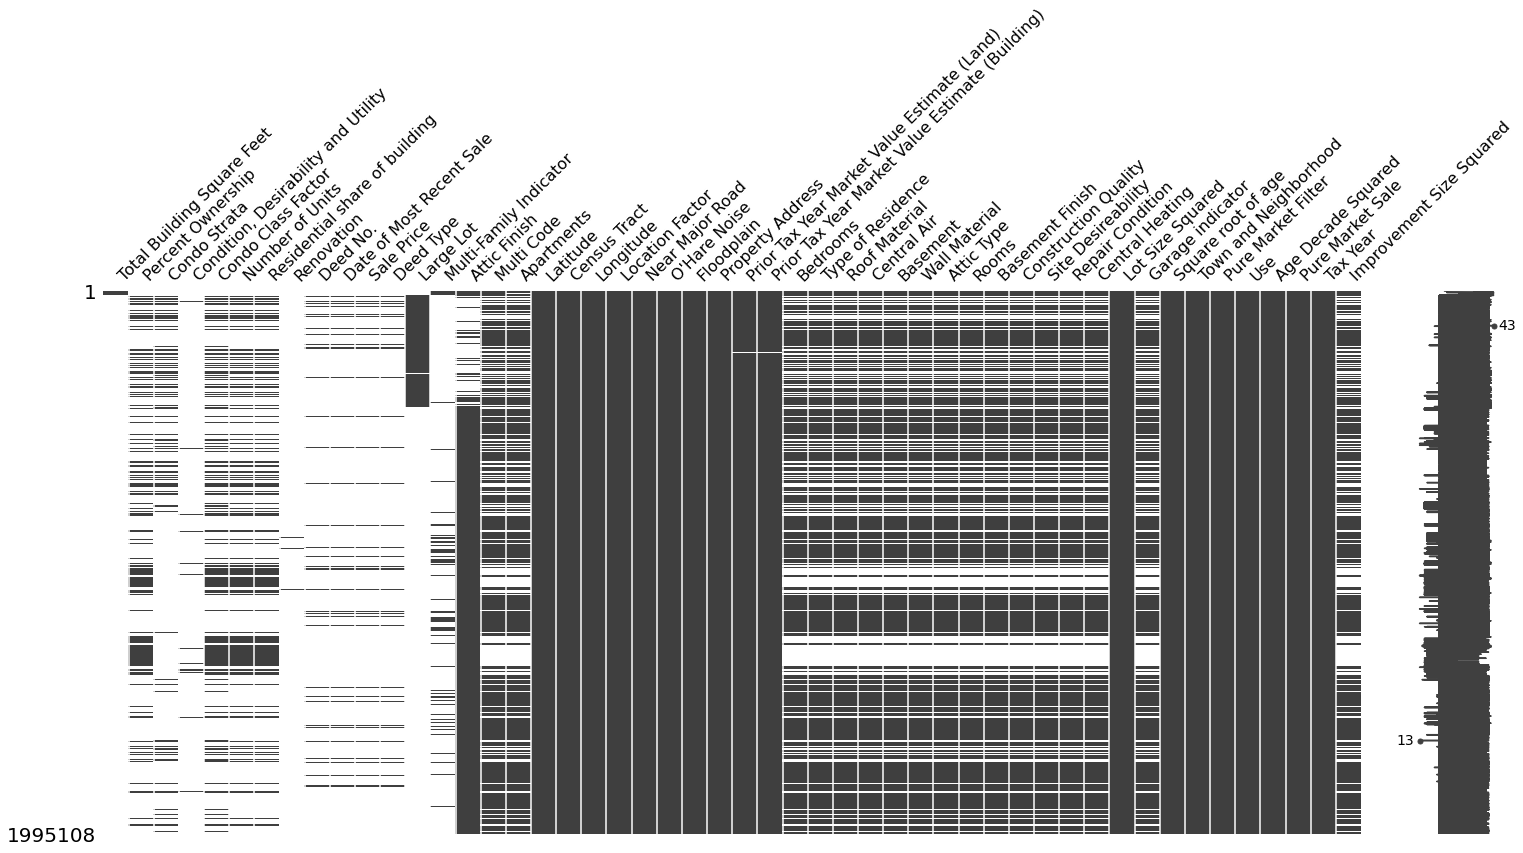

In [323]:
utils.plot_highly_missingness_correlated_cols(
    col="Total Building Square Feet", plot_df=cc_res_prop_char_df, i=0, positive_corr=False
)

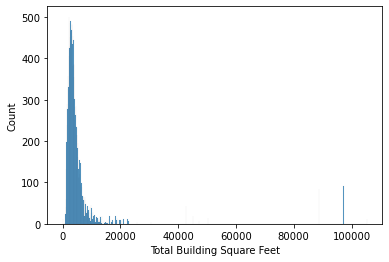

In [324]:
ax = sns.histplot(
    data=cc_res_prop_char_df, 
    x="Total Building Square Feet", 
    bins=1000
)
# ax.set_xlim(0, 1200000)

(0.0, 10000.0)

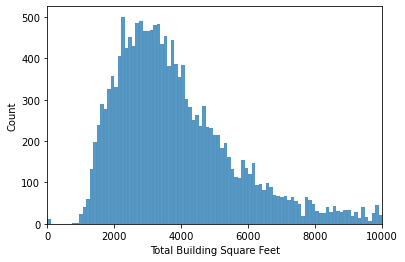

In [325]:
ax = sns.histplot(
    data=cc_res_prop_char_df, 
    x="Total Building Square Feet", 
    bins=1000
)
ax.set_xlim(0, 10000)

### Multi Property Indicator
* Indicator for a property with mutiple improvements on one PIN, e.g. a main house and a coach house. NOT to be confused with a property which was part of a multi-pin sale.

In [326]:
cc_res_prop_char_df["Multi Property Indicator"].value_counts(dropna=False)

0      1977874
1        17234
NaN          0
Name: Multi Property Indicator, dtype: Int64

In [329]:
def clean_cc_residential_prop_chars_multi_property_indicator_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Multi Property Indicator"] = df["Multi Property Indicator"].astype("boolean")
    return df

In [330]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_multi_property_indicator_col(cc_res_prop_char_df)

In [331]:
cc_res_prop_char_df["Multi Property Indicator"].value_counts(dropna=False)

False    1977874
True       17234
NaN            0
Name: Multi Property Indicator, dtype: Int64

### Property Address
* Property street address, not the address of the taxpayer.

### Modeling Group
* Modeling group, as defined by the property class. Properties with class 200, 201, 241, 299 is defined as "NCHARS", short for "no characteristics", which are condos and vacant land classes. Properties with class 202, 203, 204, 205, 206, 207, 208, 209, 210, 235, 278, and 295 are "SF", short for "single-family." Properties with class 211 and 212 are "MF", short for ""multi-family."

In [332]:
cc_res_prop_char_df["Modeling Group"].value_counts(dropna=False)

SF        1213855
NCHARS     571586
MF         179266
FIXED       30401
Name: Modeling Group, dtype: Int64

In [333]:
def clean_cc_residential_prop_chars_modeling_group_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Modeling group, as defined by the property class. Properties with
    class 200, 201, 241, 299 is defined as "NCHARS", short for "no 
    characteristics", which are condos and vacant land classes. Properties
    with class 202, 203, 204, 205, 206, 207, 208, 209, 210, 235, 278, and 295
    are "SF", short for "single-family." Properties with class 211 and 212 are
    "MF", short for ""multi-family."
    """
    df["Modeling Group"] = df["Modeling Group"].astype("category")
    return df

In [334]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_modeling_group_col(cc_res_prop_char_df)

In [335]:
cc_res_prop_char_df["Modeling Group"].value_counts(dropna=False)

SF        1213855
NCHARS     571586
MF         179266
FIXED       30401
Name: Modeling Group, dtype: int64

### Full Baths
* Number of full bathrooms, defined as having a bath or shower. If this value is missing, the default value is set to 1.

In [336]:
cc_res_prop_char_df["Full Baths"].value_counts(dropna=False)

1      807601
2      530544
NaN    485612
3      114682
4       32275
6       14694
5        8307
7         589
8         371
10        259
9          62
0          39
12         38
11         33
13          2
Name: Full Baths, dtype: Int64

In [337]:
def clean_cc_residential_prop_chars_full_baths_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Full Baths"] = df["Full Baths"].astype("Int8")
    return df

In [338]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_full_baths_col(cc_res_prop_char_df)

In [339]:
cc_res_prop_char_df["Full Baths"].value_counts(dropna=False)

1      807601
2      530544
NaN    485612
3      114682
4       32275
6       14694
5        8307
7         589
8         371
10        259
9          62
0          39
12         38
11         33
13          2
Name: Full Baths, dtype: Int64

### Age
* Age of the property. If missing, this defaults to 10. This field is a combination of original age and effective age where original age refers to the oldest component of the building and effective age is a relative judgement due to renovations or other improvements. For instance, if a property is completely demolished and built up again, the age resets to 1. But if portions of the original structure are kept, it may be more complicated to determine the age.

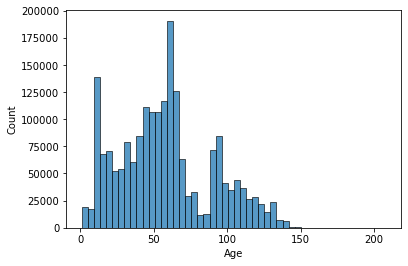

In [346]:
ax = sns.histplot(
    data=cc_res_prop_char_df, 
    x="Age", 
    bins=50
)
# ax.set_xlim(0, 10000)

In [351]:
def clean_cc_residential_prop_chars_age_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Age of the property. If missing, this defaults to 10. This field is a
    combination of original age and effective age where original age refers to
    the oldest component of the building and effective age is a relative
    judgement due to renovations or other improvements. For instance, if a
    property is completely demolished and built up again, the age resets to 1.
    But if portions of the original structure are kept, it may be more
    complicated to determine the age."""
    df["Age"] = df["Age"].astype("Int16")
    return df

In [354]:
2**16

65536

In [352]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_age_col(cc_res_prop_char_df)

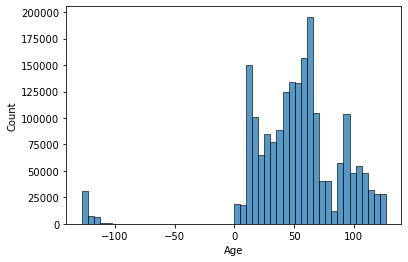

In [353]:
ax = sns.histplot(
    data=cc_res_prop_char_df, 
    x="Age", 
    bins=50
)
# ax.set_xlim(0, 10000)

### Use
* Use of property - 1 = single family, 2 = multi-family. If absent, default value is 1.

In [355]:
cc_res_prop_char_df["Use"].value_counts(dropna=False)

1      1818396
2       176712
NaN          0
Name: Use, dtype: Int64

In [ ]:
use_of_property_map = {
    1: "Single Family",
    2: "Multi Family"
}
# If absent, default value is 1.

In [ ]:
use_of_property_map = {
    1: "Single Family",
    2: "Multi Family"
}

In [358]:
def clean_cc_residential_prop_chars_use_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Use of property - 1 = single family, 2 = multi-family. If absent, 
    default value is 1."""
    use_of_property_map = {
        1: "Single Family",
        2: "Multi Family"
    }
    if "Single Family" not in df["Use"].unique():
        df["Use"] = df["Use"].map(use_of_property_map)
    df["Use"] = df["Use"].astype("category")
    return df

In [359]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_use_col(cc_res_prop_char_df)

In [360]:
cc_res_prop_char_df["Use"].value_counts(dropna=False)

Single Family    1818396
Multi Family      176712
Name: Use, dtype: int64

### Number of Units
* For condos, the number of units in a building

In [361]:
cc_res_prop_char_df["Number of Units"].value_counts(dropna=False)

NaN    1433886
6        15488
12       11676
3        10803
4         8572
        ...   
161        161
157        157
153        153
131        131
1           26
Name: Number of Units, Length: 464, dtype: Int64

In [362]:
cc_res_prop_char_df["Number of Units"].max()

1680

In [366]:
def clean_cc_residential_prop_chars_number_of_units_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """For condos, the number of units in a building"""
    df["Number of Units"] = df["Number of Units"].astype(
        "Int16"
    )
    return df

In [367]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_number_of_units_col(cc_res_prop_char_df)

In [368]:
cc_res_prop_char_df["Number of Units"].value_counts(dropna=False)

NaN    1433886
6        15488
12       11676
3        10803
4         8572
        ...   
161        161
157        157
153        153
131        131
1           26
Name: Number of Units, Length: 464, dtype: Int64

### Percent Ownership
* Percent of ownership of a condo building for a unit as defined by the condominium declaration. If missing, default is 1/n_units.

In [370]:
cc_res_prop_char_df["Percent Ownership"].value_counts(dropna=False)

NaN     1433884
0.0      219639
0.01     135264
0.02      51400
0.03      26819
         ...   
0.72          1
0.71          1
0.69          1
0.68          1
0.75          1
Name: Percent Ownership, Length: 78, dtype: Int64

### Condo Class Factor
* Factor variable for NCHARS modeling group. Divides properties into two: Properties with class 200, 201, and 241 are given condo class factor as 200. Properties with class 299 are given condo class factor as 299

In [371]:
cc_res_prop_char_df["Condo Class Factor"].value_counts(dropna=False)

NaN    1393121
299     561198
200      40789
Name: Condo Class Factor, dtype: Int64

In [372]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_condo_class_factor_col(cc_res_prop_char_df)

In [373]:
cc_res_prop_char_df["Condo Class Factor"].value_counts(dropna=False)

NaN                        1393121
residential_condominium     561198
residential_land             40789
Name: Condo Class Factor, dtype: int64

### Multi-Family Indicator
* Factor variable for MF modeling group. Properties with class 211 are given multi-family indicator as 211. Properties with class 212 are given multi-family indicator as 212.

In [374]:
cc_res_prop_char_df["Multi-Family Indicator"].value_counts(dropna=False)

NaN    1815842
211     164337
212      14929
Name: Multi-Family Indicator, dtype: Int64

In [376]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Property Class"] == 211),
    "Multi-Family Indicator"
].value_counts(dropna=False)

211    164337
NaN         0
Name: Multi-Family Indicator, dtype: Int64

In [377]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Property Class"] == 212),
    "Multi-Family Indicator"
].value_counts(dropna=False)

212    14929
NaN        0
Name: Multi-Family Indicator, dtype: Int64

In [378]:
def clean_cc_residential_prop_chars_multi_family_indicator_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Factor variable for MF modeling group. Properties with class 211 are
    given multi-family indicator as 211. Properties with class 212 are given
    multi-family indicator as 212."""
    multi_family_map = {
        211: "Yes",
        212: "Yes",
    }
    if "Yes" not in df["Multi-Family Indicator"].unique():
        df["Multi-Family Indicator"] = df["Multi-Family Indicator"].map(
            multi_family_map
        )
    df["Multi-Family Indicator"] = df["Multi-Family Indicator"].astype("category")
    return df

In [379]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_multi_family_indicator_col(cc_res_prop_char_df)

In [380]:
cc_res_prop_char_df["Multi-Family Indicator"].value_counts(dropna=False)

NaN    1815842
Yes     179266
Name: Multi-Family Indicator, dtype: int64

### Large Lot
* Large lot factor variable, where 1 acre of land (land square feet > 43559) is defined as a large lot. 1 = large lot, 0 = not a large lot. 

In [381]:
cc_res_prop_char_df["Large Lot"].value_counts(dropna=False)

NaN    1583785
0       324290
1        87033
Name: Large Lot, dtype: Int64

In [382]:
def clean_cc_residential_prop_chars_large_lot_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Large Lot"] = df["Large Lot"].astype(
        "boolean"
    )
    return df

In [383]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_large_lot_col(cc_res_prop_char_df)

In [384]:
cc_res_prop_char_df["Large Lot"].value_counts(dropna=False)

NaN      1583785
False     324290
True       87033
Name: Large Lot, dtype: Int64

### Condition, Desirability and Utility
* about 20 different codes attached to the face sheet that denote a number of seemingly unrelated characteristics associated with a PIN, ranging from condition to types of subsidies. This field does not match across the SQL server/AS-400 for 2018. 

In [385]:
cc_res_prop_char_df["Condition, Desirability and Utility"].value_counts(dropna=False)

NaN    1934899
GR       27410
AV       22915
AR        4672
GD        4355
EX         449
AX         235
LR         132
MH          26
AA           7
VG           4
LM           2
SR           1
PX           1
Name: Condition, Desirability and Utility, dtype: Int64

I spent easily 30 minutes trying to google my way to a single example of a "face sheet" without success. I don't know if there's a different term, but their [FOIA request sheet](https://prodassets.cookcountyassessor.com/s3fs-public/page_comm/FOIARequestForm.pdf) just uses "FACE SHEET".

I guess I'll just treat these as categories and maybe drop the column later.

In [386]:
def clean_cc_residential_prop_chars_cdu_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """About 20 different codes attached to the face sheet that denote a
    number of seemingly unrelated characteristics associated with a PIN,
    ranging from condition to types of subsidies. This field does not match
    across the SQL server/AS-400 for 2018."""
    df["Condition, Desirability and Utility"] = df["Condition, Desirability and Utility"].astype("category")
    return df

In [387]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_cdu_col(cc_res_prop_char_df)

In [388]:
cc_res_prop_char_df["Condition, Desirability and Utility"].value_counts(dropna=False)

NaN    1934899
GR       27410
AV       22915
AR        4672
GD        4355
EX         449
AX         235
LR         132
MH          26
AA           7
VG           4
LM           2
PX           1
SR           1
Name: Condition, Desirability and Utility, dtype: int64

### Deed Type
* literally nothing on the data documentation page.

Per this [International Association of Assessing Officers glossary](https://www.iaao.org/media/Pubs/IAAO_Glossary.pdf) linked to from the [Cook County Assessor's Office GitLab](https://gitlab.com/ccao-data-science---modeling/documentation/wiki_content/-/blob/master/Handbook/Glossary.md), these deed types could be 
* Deed,  Bargain  and  Sale
    * A  bargain  and  sale  deed  implicitly  or  explicitly asserts the grantor’s ownership of the property conveyed, but it makes no guarantees to defend the title. It provides the grant-ee more protection than a quitclaim deed but less than a special warranty deed. The words of conveyance “bargain and sale” dis-tinguish a bargain and sale deed.
* Deed, Trust
    * Broadly,  a  deed  by  which  title  to  property  is  transferred to a trustee to be held in trust. (2) Specifically, a deed by which title to property is transferred, conditionally or uncondition-ally, to a trustee to be held for the benefit of creditors or obligors of the grantor. (3) Loosely, the agreement made between an issu-er of bonds and the holders of such bonds that is deposited with the trustee, whether or not such agreement involves the transfer of property to the trustee. Also called “deed of trust.”
* Deed, Tax
    * A  deed  by  which  title  to  real  property,  sold  to  dis-charge delinquent taxes, is transferred by a tax collector or other authorized officer of the law to the purchaser at a tax sale.
* Deed, Quitclaim,
    * A deed in which the grantor conveys or relin-quishes all interests that he or she may have in a property, without warrant as to the extent or validity of such interests.
* Deed, Warranty
    * A  deed  containing  a  covenant  of  warranty  whereby the grantor of an estate of freehold guarantees that the ti-tle that he or she undertakes to transfer is free from defects and that the property is unencumbered except as stated, and whereby the grantor, for him- or herself and his or her heirs, undertakes to de-fend and protect the grantee against any loss that may be suffered by reason of the existence of any other title or interest in the prop-erty existing at the time the deed was executed and not excepted therein. Contrast deed, quitclaim.
* General Warranty Deed: 
    * The most common type of deed, a gen-eral  warranty  deed,  implicitly  promises  that  (1)  the  grantor  owns  the  property  and  may  convey  title,  (2)  there  are  no  hidden  liens  against the property, (3) no one else has better title to the property, (4)  the  grantor  will  obtain  and  deliver  any  documents  needed  to  make good the transfer, and (5) the grantor will be liable for dam-ages if future competing claims to the property prove valid.


Per [this IL study guide](https://www2.illinois.gov/rev/localgovernments/property/Documents/ptax-1-br.pdf#page=254), deed types other than **Warranty deed** or **Trustee deed** confer less than full ownership (and shouldn't be included in "sales ratio" calculations, whatever those are).

Per [this IL real estate transfer declaration form](https://www2.illinois.gov/rev/localgovernments/property/Documents/ptax-203.pdf), it looks like the deed types are
* Warranty 
* Quit Claim
* Executor
* Trustee
* Beneficial Interest
* Other ("For a deed-in-trust, limited warranty, special warranty, trust deed, or other deed types not listed on this form, select “Other” and write the deed type")

In [389]:
cc_res_prop_char_df["Deed Type"].value_counts(dropna=False)

NaN    1882731
W        65970
O        33784
T        12623
Name: Deed Type, dtype: Int64

In [391]:
def clean_cc_residential_prop_chars_deed_type_col(df: pd.DataFrame) -> pd.DataFrame:
    deed_type_map = {
        "W": "Warranty",
        "O": "Other",
        "T": "Trustee"
    }
    if "Warranty" not in df["Deed Type"].unique():        
        df["Deed Type"] = df["Deed Type"].map(deed_type_map)
    df["Deed Type"] = df["Deed Type"].astype("category")
    return df

In [392]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_deed_type_col(cc_res_prop_char_df)

In [393]:
cc_res_prop_char_df["Deed Type"].value_counts(dropna=False)

NaN         1882731
Warranty      65970
Other         33784
Trustee       12623
Name: Deed Type, dtype: int64